# Projet 6 : Classifiez automatiquement des biens de consommation


Sur la place de marché, des vendeurs proposent des articles à des acheteurs en postant une photo et une description.
Pour l'instant, l'attribution de la catégorie d'un article est effectuée manuellement par les vendeurs, et est donc peu fiable. De plus, le volume des articles est pour l’instant très petit.
Pour rendre l’expérience utilisateur des vendeurs (faciliter la mise en ligne de nouveaux articles) et des acheteurs (faciliter la recherche de produits) la plus fluide possible, et dans l'optique d'un passage à l'échelle, il devient nécessaire d'automatiser cette tâche.
Linda, Lead Data Scientist, vous demande donc d'étudier la faisabilité d'un moteur de classification des articles en différentes catégories, avec un niveau de précision suffisant.


# Prétraitement feature extraction faisabilité

<a id="0"></a> <br>
# Table of Contents 

1. [Premières observations](#1)
2. [Nettoyage et Exploration des données](#2)
3. [Traitement des données textuelles](#3)
    * [3.1 Nettoyage du texte](#4)
    * [3.2 Bag of words](#5)
        * [3.2.1 CountVectorizer](#6)
        * [3.2.2 Tf-idf](#7)
4. [Traitement des données visuelles](#8)
    * [4.1 Transformation des images](#9)
    * [4.2 Méthode SIFT](#10)
        * [Création des descripteurs de chaque image](#11)
        * [Création des clusters de descripteurs](#12)
        * [Création des features des images](#13)
        * [Réduction de dimension](#14)
        * [Analyse par classes](#15)
        * [Autre méthode de détermination du nombre de clusters](#16)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import P6_fonctions as fc
import importlib
import pickle
from IPython.display import display

from sklearn.preprocessing import LabelEncoder

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk import bigrams
from nltk import FreqDist
from string import punctuation
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF

import gensim

from os import listdir
from matplotlib.image import imread
from skimage.transform import resize
import cv2
import time
from sklearn import cluster, metrics

import tensorflow.keras as tf

In [77]:
importlib.reload(fc)

<module 'P6_fonctions' from '/Users/oceaneyouyoutte/Desktop/Data Science/OCR/Projet 6/à zip/P6_fonctions.py'>

# <a id="1"></a> 1. Premières observations

In [ ]:
data = pd.read_csv('Flipkart/flipkart_com-ecommerce_sample_1050.csv')

In [ ]:
data.head()

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   
2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56 +0000   
3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52 +0000   
4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...  
2  {"product_specification"=>[{"key"=>"Material",...  
3  {"product_specification"=>[{"key"=>"Brand", "v...  
4  {"product_specification"=>[{"key"=>"Machine Wa...

In [ ]:
data.shape

(1050, 15)

In [ ]:
data.columns

Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications'],
      dtype='object')

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050 entries, 0 to 1049
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   uniq_id                  1050 non-null   object 
 1   crawl_timestamp          1050 non-null   object 
 2   product_url              1050 non-null   object 
 3   product_name             1050 non-null   object 
 4   product_category_tree    1050 non-null   object 
 5   pid                      1050 non-null   object 
 6   retail_price             1049 non-null   float64
 7   discounted_price         1049 non-null   float64
 8   image                    1050 non-null   object 
 9   is_FK_Advantage_product  1050 non-null   bool   
 10  description              1050 non-null   object 
 11  product_rating           1050 non-null   object 
 12  overall_rating           1050 non-null   object 
 13  brand                    712 non-null    object 
 14  product_specifications  

Les données fournies (images et texte) ont été vérifiées par Linda et ne posent aucune contrainte de propriété intellectuelle. Nous pouvons commencer notre exploitation.

# <a id="2"></a> 2. Nettoyage et Exploration des données

Conversion de la colonne *'crawl_timestamp'* en format datetime.

In [ ]:
data['crawl_timestamp'] = data['crawl_timestamp'].apply(pd.to_datetime, format='%Y-%m-%d %H:%M:%S.%f')

In [ ]:
data.describe()

retail_price  discounted_price
count    1049.000000       1049.000000
mean     2186.197331       1584.527169
std      7639.229411       7475.099680
min        35.000000         35.000000
25%       555.000000        340.000000
50%       999.000000        600.000000
75%      1999.000000       1199.000000
max    201000.000000     201000.000000

In [ ]:
fc.missing_general(data)

Nombre total de cellules manquantes : 341
Nombre de cellules manquantes en % : 2.17%


In [ ]:
fc.valeurs_manquantes(data)

Variable  Missing values  Missing (%)
0                   uniq_id               0     0.000000
1           crawl_timestamp               0     0.000000
2               product_url               0     0.000000
3              product_name               0     0.000000
4     product_category_tree               0     0.000000
5                       pid               0     0.000000
6              retail_price               1     0.000952
7          discounted_price               1     0.000952
8                     image               0     0.000000
9   is_FK_Advantage_product               0     0.000000
10              description               0     0.000000
11           product_rating               0     0.000000
12           overall_rating               0     0.000000
13                    brand             338     0.321905
14   product_specifications               1     0.000952

Il y a 2.17% de valeurs manquantes dans le dataframe. Ces valeurs sont essentiellement situées dans la variable *'brand'*. Il y en a également 1 dans chacune des variables suivantes : *'retail_price'*, *'discounted_price'*, et *'product_specifications'*.

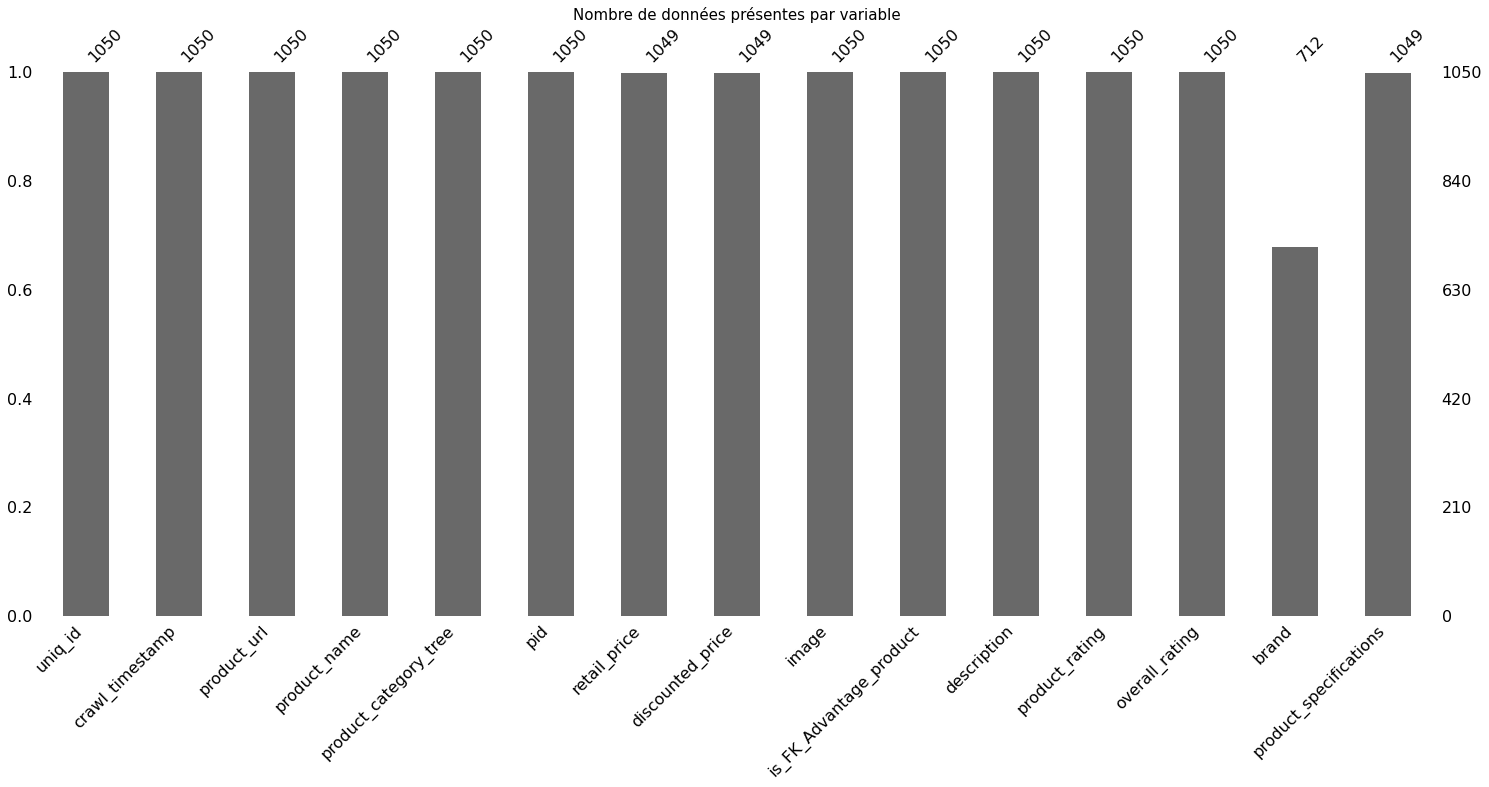

In [ ]:
fc.bar_missing(data)

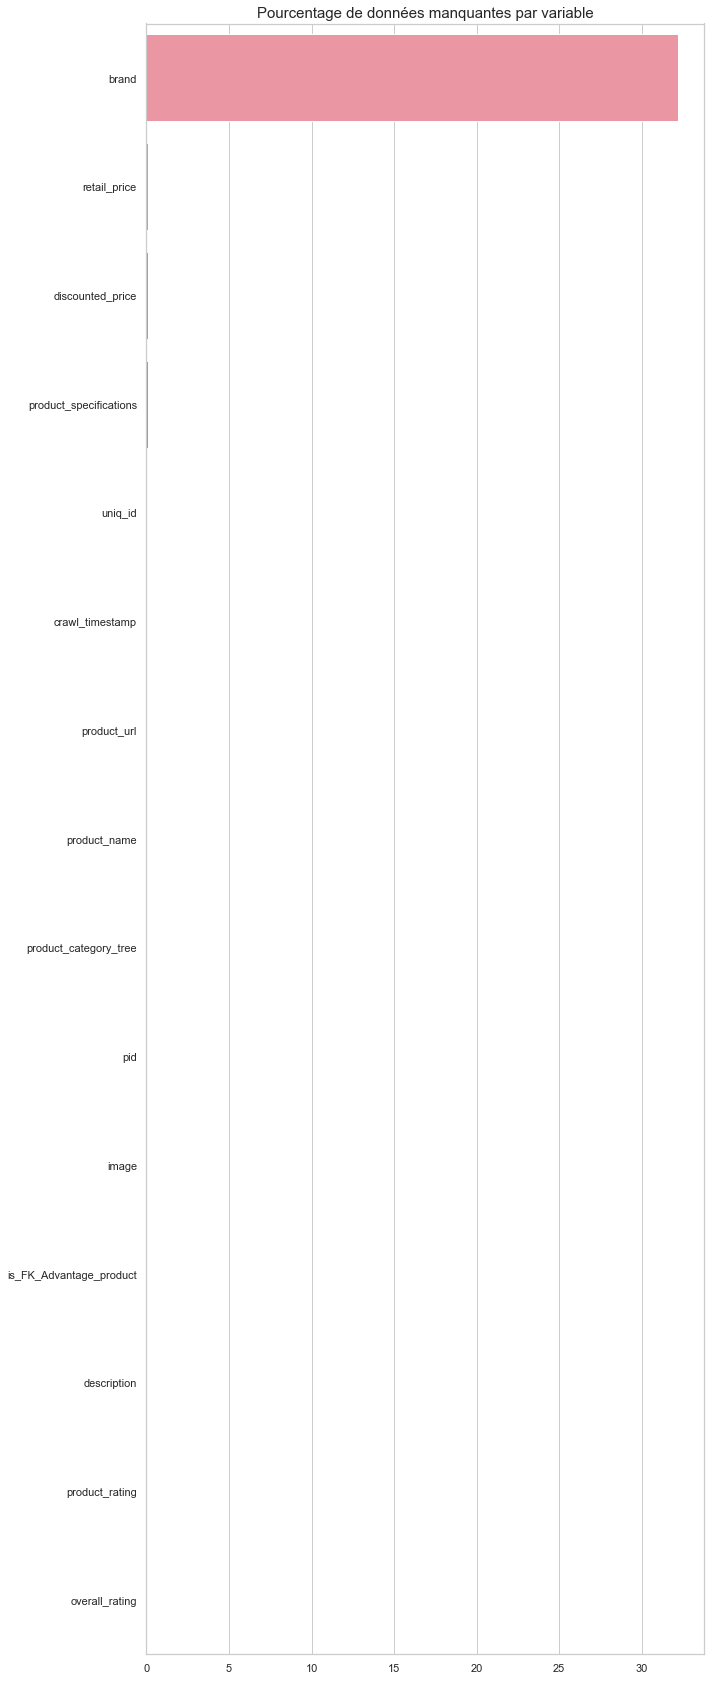

In [ ]:
fc.barplot_missing(data)

Nous allons désormais observer si le dataframe comporte des données dupliquées.

In [ ]:
print("Nombre de commandes dupliquées : ", data[data.duplicated()].shape[0])
data[data.duplicated(keep=False)]

Nombre de commandes dupliquées :  0


Empty DataFrame
Columns: [uniq_id, crawl_timestamp, product_url, product_name, product_category_tree, pid, retail_price, discounted_price, image, is_FK_Advantage_product, description, product_rating, overall_rating, brand, product_specifications]
Index: []

Nous n'avons donc pas de données dupliquées ici.

Voyons maintenant plus en détail la variable *'product_category_tree'* qui est la variable qui nous intéresse dans le cadre de la prédiction de la catégorie d'un article.

In [ ]:
data[['product_category_tree']]

product_category_tree
0     ["Home Furnishing >> Curtains & Accessories >>...
1     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
2     ["Baby Care >> Baby Bath & Skin >> Baby Bath T...
3     ["Home Furnishing >> Bed Linen >> Bedsheets >>...
4     ["Home Furnishing >> Bed Linen >> Bedsheets >>...
...                                                 ...
1045  ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1046  ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1047  ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1048  ["Baby Care >> Baby & Kids Gifts >> Stickers >...
1049  ["Baby Care >> Baby & Kids Gifts >> Stickers >...

[1050 rows x 1 columns]

Nous allons séparer en plusieurs variables les différents niveaux de catégories.

In [ ]:
df_cat = data.copy()

In [ ]:
df_cat['product_category_tree'].str.count(" >> ").max()

6

In [ ]:
df_cat['product_category_tree'].str.count(" >> ").median()

3.0

In [ ]:
def split_categories(categories):
    categories = categories.replace('["', "").replace('"]', "")
    cat_list = categories.split(' >> ')
    
    cat = pd.Series(dtype='object')
    for i in range(0, len(cat_list)):
        cat["cat_{}".format(i+1)] = cat_list[i]
    
    return cat

In [ ]:
category = pd.DataFrame()
category = df_cat['product_category_tree'].apply(split_categories)

In [ ]:
category

cat_1                   cat_2             cat_3  \
0     Home Furnishing  Curtains & Accessories          Curtains   
1           Baby Care        Baby Bath & Skin  Baby Bath Towels   
2           Baby Care        Baby Bath & Skin  Baby Bath Towels   
3     Home Furnishing               Bed Linen         Bedsheets   
4     Home Furnishing               Bed Linen         Bedsheets   
...               ...                     ...               ...   
1045        Baby Care       Baby & Kids Gifts          Stickers   
1046        Baby Care       Baby & Kids Gifts          Stickers   
1047        Baby Care       Baby & Kids Gifts          Stickers   
1048        Baby Care       Baby & Kids Gifts          Stickers   
1049        Baby Care       Baby & Kids Gifts          Stickers   

                                                  cat_4  \
0     Elegance Polyester Multicolor Abstract Eyelet ...   
1                             Sathiyas Baby Bath Towels   
2                              Eurospa Baby Bath Towels   
3                       SANTOSH ROYAL FASHION Bedsheets   
4                                Jaipur Print Bedsheets   
...                                                 ...   
1045                              Oren Empower Stickers   
1046                                Wallmantra Stickers   
1047                                  Uberlyfe Stickers   
1048                                Wallmantra Stickers   
1049                                  Uberlyfe Stickers   

                                                  cat_5 cat_6 cat_7  
0                                                   NaN   NaN   NaN  
1     Sathiyas Cotton Bath Towel (3 Bath Towel, Red,...   NaN   NaN  
2     Eurospa Cotton Terry Face Towel Set (20 PIECE ...   NaN   NaN  
3     SANTOSH ROYAL FASHION Cotton Printed King size...   NaN   NaN  
4     Jaipur Print Cotton Floral King sized Double B...   NaN   NaN  
...                                                 ...   ...   ...  
1045                                                NaN   NaN   NaN  
1046                                                NaN   NaN   NaN  
1047                                                NaN   NaN   NaN  
1048                                                NaN   NaN   NaN  
1049                                                NaN   NaN   NaN  

[1050 rows x 7 columns]

In [ ]:
fc.valeurs_manquantes(category)

Variable  Missing values  Missing (%)
0    cat_1               0     0.000000
1    cat_2               0     0.000000
2    cat_3               3     0.002857
3    cat_4             371     0.353333
4    cat_5             645     0.614286
5    cat_6             923     0.879048
6    cat_7             993     0.945714

On constate que seules les 3 premières catégories sont quasiment toutes renseignées. Nous décidons donc de ne garder quel celles-ci et de remplacer les 3 valeurs manquantes par *'None'*.

In [ ]:
category.drop(["cat_{}".format(i) for i in range(4,8)], axis=1, inplace=True)

In [ ]:
category.fillna('None', inplace=True)

In [ ]:
fc.valeurs_manquantes(category)

Variable  Missing values  Missing (%)
0    cat_1               0          0.0
1    cat_2               0          0.0
2    cat_3               0          0.0

In [ ]:
df_cat = pd.concat(
    [df_cat, category],
    sort=False,
    axis=1)

In [ ]:
df_cat.head()

uniq_id           crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56+00:00   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56+00:00   
3  d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52+00:00   
4  6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications            cat_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

                    cat_2             cat_3  
0  Curtains & Accessories          Curtains  
1        Baby Bath & Skin  Baby Bath Towels  
2        Baby Bath & Skin  Baby Bath Towels  
3               Bed Linen         Bedsheets  
4               Bed Linen         Bedsheets

In [ ]:
le = LabelEncoder()
le.fit(df_cat["cat_1"])
df_cat["label"] = le.transform(df_cat["cat_1"])

In [ ]:
df_cat.head()

uniq_id           crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7 2016-04-30 03:22:56+00:00   
1  7b72c92c2f6c40268628ec5f14c6d590 2016-04-30 03:22:56+00:00   
2  64d5d4a258243731dc7bbb1eef49ad74 2016-04-30 03:22:56+00:00   
3  d4684dcdc759dd9cdf41504698d737d8 2016-06-20 08:49:52+00:00   
4  6325b6870c54cd47be6ebfbffa620ec7 2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   
2                    False  Key Features of Eurospa Cotton Terry Face Towe...   
3                    False  Key Features of SANTOSH ROYAL FASHION Cotton P...   
4                    False  Key Features of Jaipur Print Cotton Floral Kin...   

        product_rating       overall_rating                  brand  \
0  No rating available  No rating available               Elegance   
1  No rating available  No rating available               Sathiyas   
2  No rating available  No rating available                Eurospa   
3  No rating available  No rating available  SANTOSH ROYAL FASHION   
4  No rating available  No rating available           Jaipur Print   

                              product_specifications            cat_1  \
0  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
1  {"product_specification"=>[{"key"=>"Machine Wa...        Baby Care   
2  {"product_specification"=>[{"key"=>"Material",...        Baby Care   
3  {"product_specification"=>[{"key"=>"Brand", "v...  Home Furnishing   
4  {"product_specification"=>[{"key"=>"Machine Wa...  Home Furnishing   

                    cat_2             cat_3  label  
0  Curtains & Accessories          Curtains      4  
1        Baby Bath & Skin  Baby Bath Towels      0  
2        Baby Bath & Skin  Baby Bath Towels      0  
3               Bed Linen         Bedsheets      4  
4               Bed Linen         Bedsheets      4

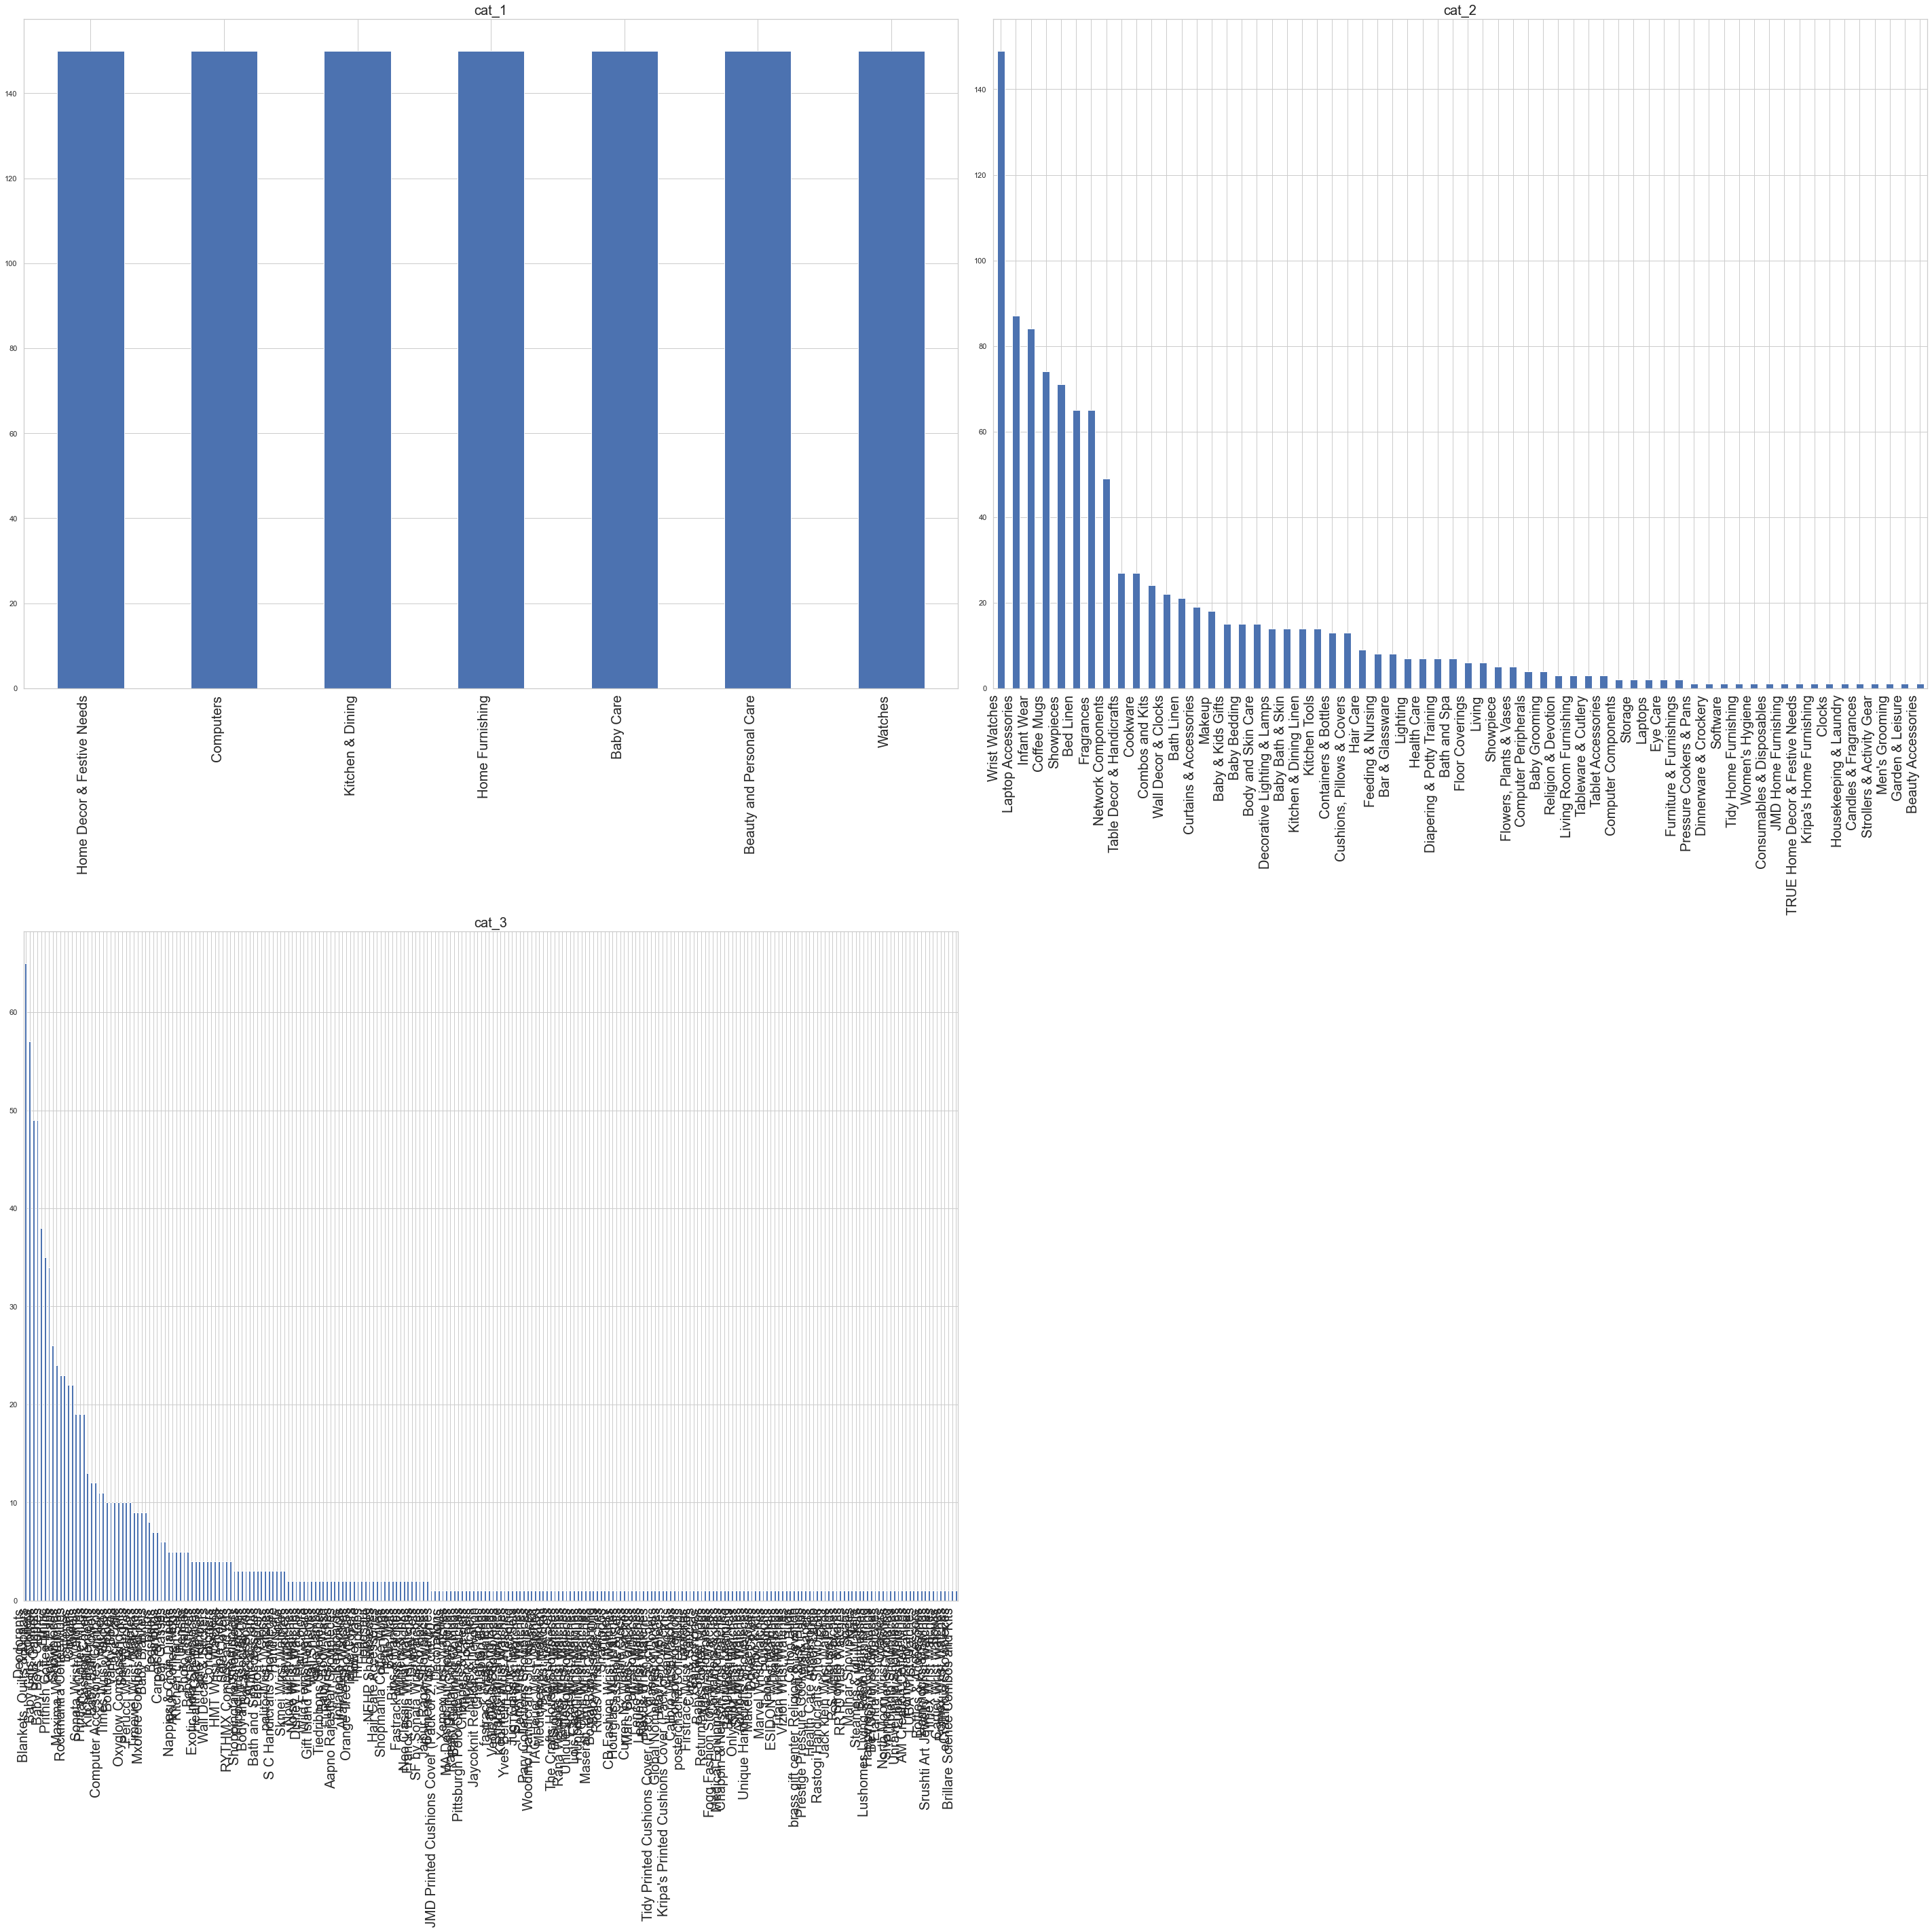

In [ ]:
fc.bar_plot(df_cat, ['cat_1', 'cat_2', 'cat_3'], 2, 2)

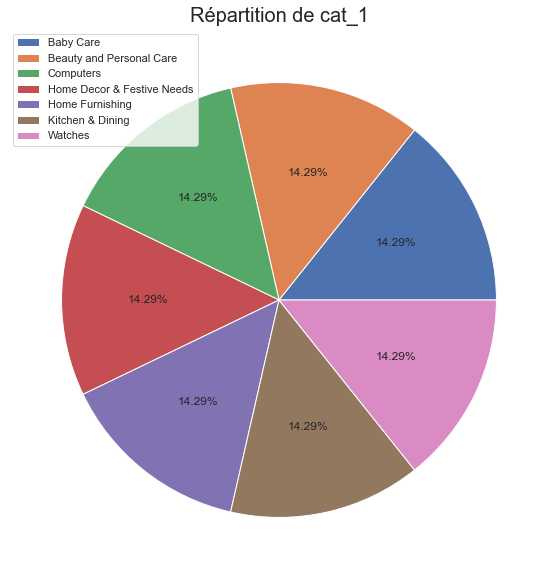

In [ ]:
fc.pie_plot(df_cat, ['cat_1'])

On constate que pour la catégorie principale des produits ('cat_1'), est parfaitement équilibrée avec 150 produits dans chaque catégorie.

In [ ]:
df_cat.to_csv('data_categories.csv')

# <a id="3"></a> 3. Traitement des données textuelles

## <a id="4"></a> 3.1 Nettoyage du texte

In [ ]:
df_cat[['description']]

description
0     Key Features of Elegance Polyester Multicolor ...
1     Specifications of Sathiyas Cotton Bath Towel (...
2     Key Features of Eurospa Cotton Terry Face Towe...
3     Key Features of SANTOSH ROYAL FASHION Cotton P...
4     Key Features of Jaipur Print Cotton Floral Kin...
...                                                 ...
1045  Oren Empower Extra Large Self Adhesive Sticker...
1046  Wallmantra Large Vinyl Sticker Sticker (Pack o...
1047  Buy Uberlyfe Extra Large Pigmented Polyvinyl F...
1048  Buy Wallmantra Medium Vinyl Sticker Sticker fo...
1049  Buy Uberlyfe Large Vinyl Sticker for Rs.595 on...

[1050 rows x 1 columns]

In [ ]:
df_cat['description'].iloc[0]

'Key Features of Elegance Polyester Multicolor Abstract Eyelet Door Curtain Floral Curtain,Elegance Polyester Multicolor Abstract Eyelet Door Curtain (213 cm in Height, Pack of 2) Price: Rs. 899 This curtain enhances the look of the interiors.This curtain is made from 100% high quality polyester fabric.It features an eyelet style stitch with Metal Ring.It makes the room environment romantic and loving.This curtain is ant- wrinkle and anti shrinkage and have elegant apparance.Give your home a bright and modernistic appeal with these designs. The surreal attention is sure to steal hearts. These contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening, you create the most special moments of joyous beauty given by the soothing prints. Bring home the elegant curtain that softly filters light in your room so that you

Nous créons une liste de stopwords à éliminer comprenant les stops words du vocabulaire anglais ainsi que la ponctuation. Ce sont les mots très courants dans la langue étudiée ("et", "à", "le"... en français) qui n'apportent pas de valeur informative pour la compréhension du "sens" d'un document. 

In [ ]:
stopwords_nltk = set(stopwords.words('english'))
stopwords_punct = set(punctuation)

stop_words = set.union(stopwords_nltk, stopwords_punct)

In [ ]:
df_cat.shape

(1050, 19)

Nous allons désormais appliquer différentes transformations sur notre texte :
- suppression des stopwords
- tokénisation : C'est un processus de division d'une chaîne de texte en un ensemble de "tokens" ou unités de sens. Un token peut être un mot, une ponctuation, un nombre, un symbole ou toute autre unité significative dans un texte.
- lemmatisation : représenter les mots (ou « lemmes ») sous leur forme canonique. Par exemple pour un verbe, ce sera son infinitif. Pour un nom, son masculin singulier. L'idée étant de ne conserver que le sens des mots utilisés dans le corpus.
- stemming (ou racinisation): consiste à ne conserver que la racine des mots étudiés. L'idée étant de supprimer les suffixes, préfixes et autres des mots afin de ne conserver que leur origine. C'est un procédé plus simple que la lemmatisation et plus rapide à effectuer puisqu'on tronque les mots essentiellement contrairement à la lemmatisation qui nécessite d'utiliser un dictionnaire.

Nous créons de nouvelles variables dans notre dataframe, comprenant les différentes transformations réalisées sur la variable description.

Nous avons la description qui a été mise en minuscule, tokenisée et les stopwords ont été retirés dans la variable *'descr_bow'*.
La variable *'descr_bow_lem'* comporte les mêmes étapes mais avec une étape de lemmatisation en plus.
De même pour la variable *'descr_bow_stem'* mais avec une étape de stemming.
Ces variables sont des préparations du texte pour le bag of words.

Enfin, *'descr_dl'* est une préparation du texte pour le Deep learning (avec des algorithmes tels que USE et BERT). Elle consiste à tokéniser et mettre en minuscule la description.

In [ ]:
df_cat['descr_bow'] = df_cat['description'].apply(lambda x : fc.transform_bow_fct(x, stop_words))
df_cat['length_bow'] = df_cat['descr_bow'].apply(lambda x : len(word_tokenize(x)))
print("max length bow : ", df_cat['length_bow'].max())

df_cat['descr_bow_lem'] = df_cat['description'].apply(lambda x : fc.transform_bow_lem_fct(x, stop_words))
df_cat['length_bow_lem'] = df_cat['descr_bow_lem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow lem : ", df_cat['length_bow_lem'].max())

df_cat['descr_bow_stem'] = df_cat['description'].apply(lambda x : fc.transform_bow_stem_fct(x, stop_words))
df_cat['length_bow_stem'] = df_cat['descr_bow_stem'].apply(lambda x : len(word_tokenize(x)))
print("max length bow stem : ", df_cat['length_bow_stem'].max())

df_cat['descr_dl'] = df_cat['description'].apply(lambda x : fc.transform_dl_fct(x))
df_cat['length_dl'] = df_cat['descr_dl'].apply(lambda x : len(word_tokenize(x)))
print("max length dl : ", df_cat['length_dl'].max())

max length bow :  379
max length bow lem :  379
max length bow stem :  379
max length dl :  640


Voici la démonstration de l'application des différentes fonctions sur une descritption.

In [ ]:
df_cat['descr_bow'].iloc[0]

'key features elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it features eyelet style stitch metal ring.it makes room environment romantic loving.this curtain ant- wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal designs the surreal attention sure steal hearts these contemporary eyelet valance curtains slide smoothly draw apart first thing morning welcome bright sun rays want wish good morning whole world draw close evening create special moments joyous beauty given soothing prints bring home elegant curtain softly filters light room get right amount sunlight. specifications elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25

In [ ]:
df_cat['descr_bow_lem'].iloc[0]

'key feature elegance polyester multicolor abstract eyelet door curtain floral curtain elegance polyester multicolor abstract eyelet door curtain 213 height pack price 899 this curtain enhances look interiors.this curtain made 100 high quality polyester fabric.it feature eyelet style stitch metal ring.it make room environment romantic loving.this curtain ant- wrinkle anti shrinkage elegant apparance.give home bright modernistic appeal design the surreal attention sure steal heart these contemporary eyelet valance curtain slide smoothly draw apart first thing morning welcome bright sun ray want wish good morning whole world draw close evening create special moment joyous beauty given soothing print bring home elegant curtain softly filter light room get right amount sunlight. specification elegance polyester multicolor abstract eyelet door curtain 213 height pack general brand elegance designed for door type eyelet model name abstract polyester door curtain set model duster25 color mult

In [ ]:
df_cat['descr_bow_stem'].iloc[0]

'key featur eleg polyest multicolor abstract eyelet door curtain floral curtain eleg polyest multicolor abstract eyelet door curtain 213 height pack price 899 thi curtain enhanc look interiors.thi curtain made 100 high qualiti polyest fabric.it featur eyelet style stitch metal ring.it make room environ romant loving.thi curtain ant- wrinkl anti shrinkag eleg apparance.g home bright modernist appeal design the surreal attent sure steal heart these contemporari eyelet valanc curtain slide smoothli draw apart first thing morn welcom bright sun ray want wish good morn whole world draw close even creat special moment joyou beauti given sooth print bring home eleg curtain softli filter light room get right amount sunlight. specif eleg polyest multicolor abstract eyelet door curtain 213 height pack gener brand eleg design for door type eyelet model name abstract polyest door curtain set model duster25 color multicolor dimens length 213 box number content sale packag pack sale packag curtain b

In [ ]:
df_cat['descr_dl'].iloc[0]

'key features of elegance polyester multicolor abstract eyelet door curtain floral curtain , elegance polyester multicolor abstract eyelet door curtain ( 213 cm in height , pack of 2 ) price : rs . 899 this curtain enhances the look of the interiors.this curtain is made from 100 % high quality polyester fabric.it features an eyelet style stitch with metal ring.it makes the room environment romantic and loving.this curtain is ant- wrinkle and anti shrinkage and have elegant apparance.give your home a bright and modernistic appeal with these designs . the surreal attention is sure to steal hearts . these contemporary eyelet and valance curtains slide smoothly so when you draw them apart first thing in the morning to welcome the bright sun rays you want to wish good morning to the whole world and when you draw them close in the evening , you create the most special moments of joyous beauty given by the soothing prints . bring home the elegant curtain that softly filters light in your room

In [ ]:
df_cat.shape

(1050, 27)

In [ ]:
df_cat.to_csv("data_text_clean.csv")

**Les co-occurences :**

On peut traiter chaque mot comme ayant une probabilité d'apparition en fonction du texte qui le précède, c'est à dire comme une séquence. En pratique, on peut prendre les quelques mots précédents qui représentent assez d'information pour avoir un modèle séquentiel (markovien) intéressant, d'où l'apparition des n-grammes.

En pratique, on peut aussi utiliser la fonction bigrams de NLTK.

In [ ]:
tokens = word_tokenize(df_cat['descr_dl'].iloc[0])
list(bigrams(tokens))

[('key', 'features'),
 ('features', 'of'),
 ('of', 'elegance'),
 ('elegance', 'polyester'),
 ('polyester', 'multicolor'),
 ('multicolor', 'abstract'),
 ('abstract', 'eyelet'),
 ('eyelet', 'door'),
 ('door', 'curtain'),
 ('curtain', 'floral'),
 ('floral', 'curtain'),
 ('curtain', ','),
 (',', 'elegance'),
 ('elegance', 'polyester'),
 ('polyester', 'multicolor'),
 ('multicolor', 'abstract'),
 ('abstract', 'eyelet'),
 ('eyelet', 'door'),
 ('door', 'curtain'),
 ('curtain', '('),
 ('(', '213'),
 ('213', 'cm'),
 ('cm', 'in'),
 ('in', 'height'),
 ('height', ','),
 (',', 'pack'),
 ('pack', 'of'),
 ('of', '2'),
 ('2', ')'),
 (')', 'price'),
 ('price', ':'),
 (':', 'rs'),
 ('rs', '.'),
 ('.', '899'),
 ('899', 'this'),
 ('this', 'curtain'),
 ('curtain', 'enhances'),
 ('enhances', 'the'),
 ('the', 'look'),
 ('look', 'of'),
 ('of', 'the'),
 ('the', 'interiors.this'),
 ('interiors.this', 'curtain'),
 ('curtain', 'is'),
 ('is', 'made'),
 ('made', 'from'),
 ('from', '100'),
 ('100', '%'),
 ('%', 'high

In [ ]:
tokens = word_tokenize(df_cat['descr_bow'].iloc[0])
list(bigrams(tokens))

[('key', 'features'),
 ('features', 'elegance'),
 ('elegance', 'polyester'),
 ('polyester', 'multicolor'),
 ('multicolor', 'abstract'),
 ('abstract', 'eyelet'),
 ('eyelet', 'door'),
 ('door', 'curtain'),
 ('curtain', 'floral'),
 ('floral', 'curtain'),
 ('curtain', 'elegance'),
 ('elegance', 'polyester'),
 ('polyester', 'multicolor'),
 ('multicolor', 'abstract'),
 ('abstract', 'eyelet'),
 ('eyelet', 'door'),
 ('door', 'curtain'),
 ('curtain', '213'),
 ('213', 'height'),
 ('height', 'pack'),
 ('pack', 'price'),
 ('price', '899'),
 ('899', 'this'),
 ('this', 'curtain'),
 ('curtain', 'enhances'),
 ('enhances', 'look'),
 ('look', 'interiors.this'),
 ('interiors.this', 'curtain'),
 ('curtain', 'made'),
 ('made', '100'),
 ('100', 'high'),
 ('high', 'quality'),
 ('quality', 'polyester'),
 ('polyester', 'fabric.it'),
 ('fabric.it', 'features'),
 ('features', 'eyelet'),
 ('eyelet', 'style'),
 ('style', 'stitch'),
 ('stitch', 'metal'),
 ('metal', 'ring.it'),
 ('ring.it', 'makes'),
 ('makes', 'roo

**Les mots les plus fréquents**

Nous affichons les mots qui reviennent le plus féquemment dans les descriptions.

Text(0.5, 1.0, 'Les 20 mots les plus fréquents des descriptions')

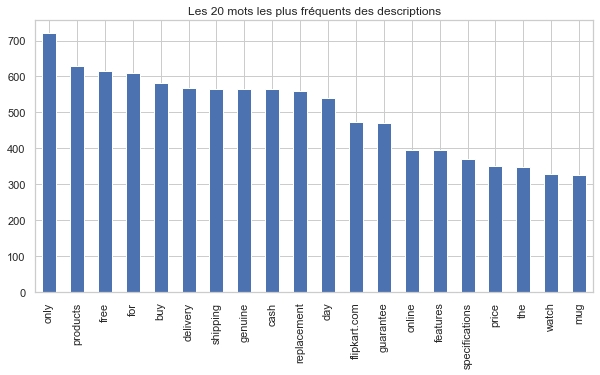

In [ ]:
tokens = word_tokenize(' '.join(df_cat['descr_bow'].values))
# on compte la fréquence de chaque mot 
freq_desc = pd.Series(FreqDist(tokens))

fig = plt.figure(figsize=(10,5))
freq_desc.sort_values(ascending=False)[0:20].plot.bar()
plt.title('Les 20 mots les plus fréquents des descriptions')


Nous affichons désormais les mots qui reviennent le plus féquemment dans les descriptions pour chaque cluster.

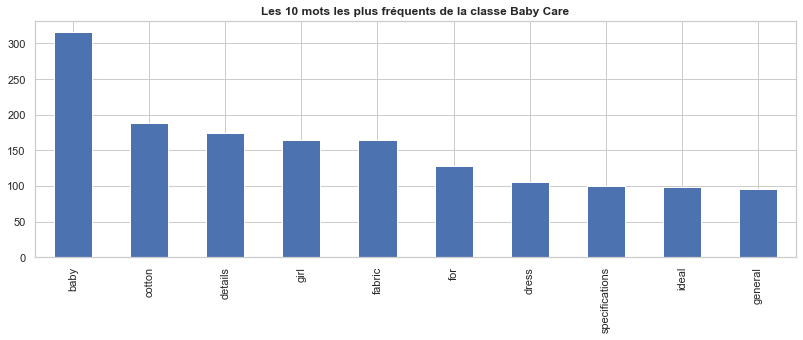

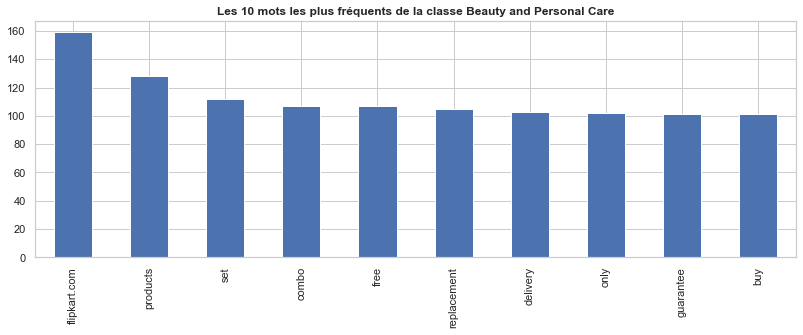

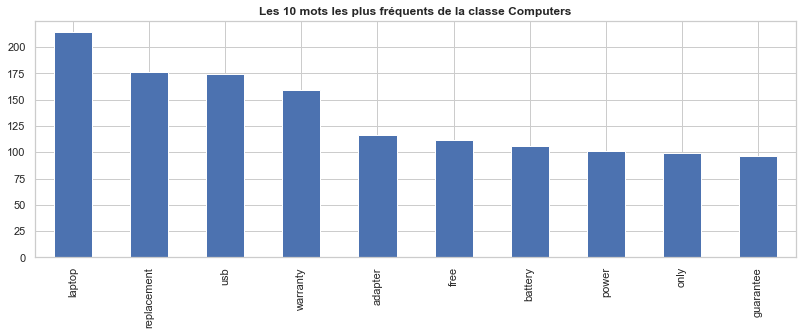

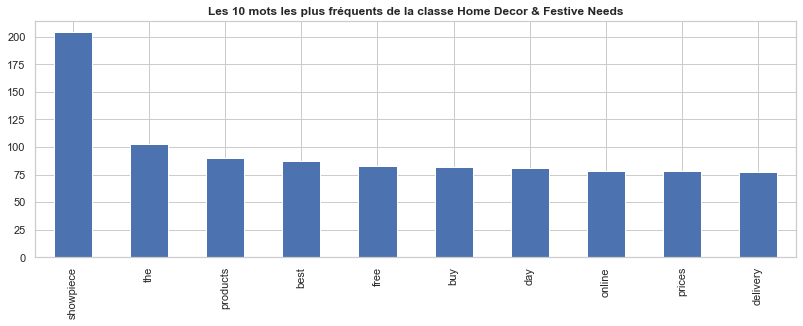

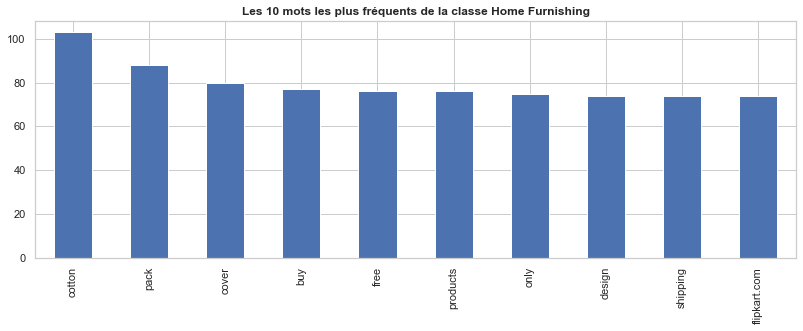

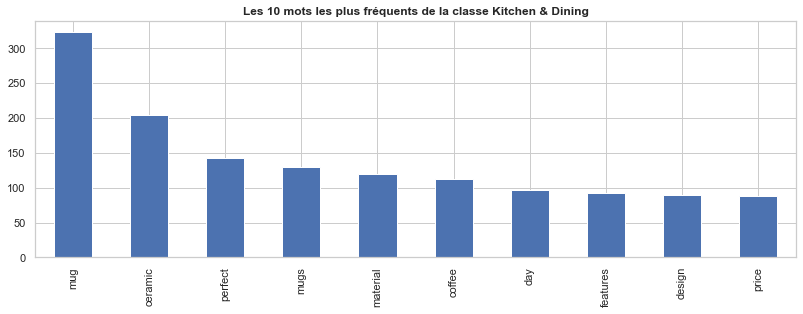

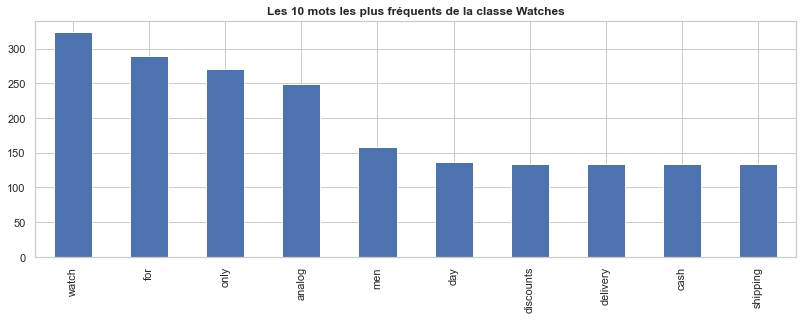

In [ ]:
df = df_cat.groupby(['cat_1'])['descr_bow'].agg(lambda x : ' '.join(x))

for i in range(df.shape[0]):
    tokens = word_tokenize(df[i])
    # on compte la fréquence de chaque mot 
    freq_desc = pd.Series(FreqDist(tokens))

    fig = plt.figure(figsize=(30,20))
    ax = fig.add_subplot(4,2,i+1)
    freq_desc.sort_values(ascending=False)[0:10].plot.bar(ax=ax)
    ax.set_title("Les 10 mots les plus fréquents de la classe {}".format(df.index[i]), fontweight='bold')
    
plt.show()

On constate que pour certaines catégories, les mots les plus fréquents sont réellement relatifs à cette catégorie. C'est le cas par exemple pour la catégorie *Baby Care*, avec les mots *baby* ou *cotton*, ou encore la catégorie *Computers* avec *laptop*, *usb* ou encore *battery*. D'autres catégories ont des mots fréquents moins spécifiques, comme pour la catégorie *Beauty and Personal Care* par exemple. 

## <a id="5"></a> 3.2 Bag of words

Le bag of words est une méthode de représentation de texte dans le domaine du traitement de texte. Elle consiste à représenter un document ou une phrase sous la forme d'un ensemble de mots, en ignorant l'ordre dans lequel ils apparaissent et en ne prenant en compte que leur fréquence d'apparition.

In [ ]:
df_cat['cat_1'].nunique()

7

Il y a 7 catégories principales. Nous créerons donc 7 clusters lors de notre modélisation.

In [ ]:
df_cat['cat_1'].unique()

array(['Home Furnishing', 'Baby Care', 'Watches',
       'Home Decor & Festive Needs', 'Kitchen & Dining',
       'Beauty and Personal Care', 'Computers'], dtype=object)

In [100]:
df_cat.groupby('label')['cat_1'].max()

label
0                     Baby Care
1      Beauty and Personal Care
2                     Computers
3    Home Decor & Festive Needs
4               Home Furnishing
5              Kitchen & Dining
6                       Watches
Name: cat_1, dtype: object

In [6]:
liste_cat = ['Baby Care','Beauty and Personal Care','Computers','Home Decor & Festive Needs',
            'Home Furnishing','Kitchen & Dining','Watches']

Nous utilisons les descriptions qui ont été mise en minuscule, tokenisée, dont les stopwords ont été retirés et lemmatisées. 

In [7]:
feat = 'descr_bow_lem'

### <a id="6"></a> 3.2.1 CountVectorizer

CountVectorizer transforme chaque document en un vecteur de nombres entiers qui représentent le nombre d'occurrences de chaque mot dans le document.

Les paramètres *max_df* et *min_df* sont utilisés pour contrôler la sélection des mots à inclure dans la matrice de compte de termes générée par CountVectorizer.
Ici, cela signifie que les mots présents dans plus de 95% des documents seront ignorés et les mots présents dans moins de 1 document seront ignorés.

In [8]:
cv = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
cv_fit = cv.fit(df_cat[feat])
cv_transform = cv.transform(df_cat[feat])  

In [9]:
pickle.dump(cv_transform, open('models/list_features_CountVectorizer.pkl', 'wb'))

Afin de pouvoir visualiser nos données sur une représentation 2D, nous appliquons un TSNE à 2 composantes.

In [10]:
print("CountVectorizer : ")
print("-----------------")
ARI_cv, X_tsne_cv, labels_cv = fc.ARI_fct_tsne(cv_transform, liste_cat, df_cat["label"])

CountVectorizer : 
-----------------
ARI :  0.4184 time :  6.0


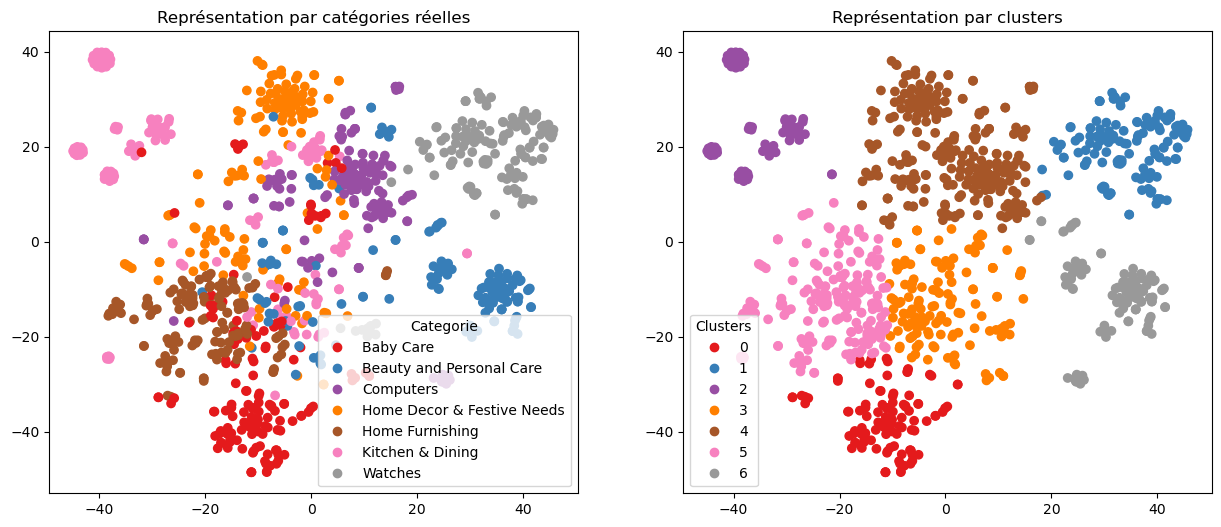

ARI :  0.4184


In [41]:
fc.TSNE_visu_fct(X_tsne_cv, liste_cat, df_cat["label"], labels_cv, ARI_cv)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réelle. En effet, on constate que certaines catégories se mélangent plus dans la représentation réelle (*Home Decor & Festive Needs*, *Home Furnishing* et *Kitchen & Dining* par exemple). D'autres clusters semblent assez bien déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches*, *Beauty and Personal Care* ou encore *Baby Care*.

L'ARI (Adjusted Rand Index ou Indice Rand Ajusté) est une mesure de la similarité entre deux clustering de données. Il s'agit d'une correction du Rand Index (RI), qui est une mesure basique de similarité entre deux clusterings, mais il a l'inconvénient d'être sensible au hasard. Ici nous obtenons un assez bon ARI à 0.4184.

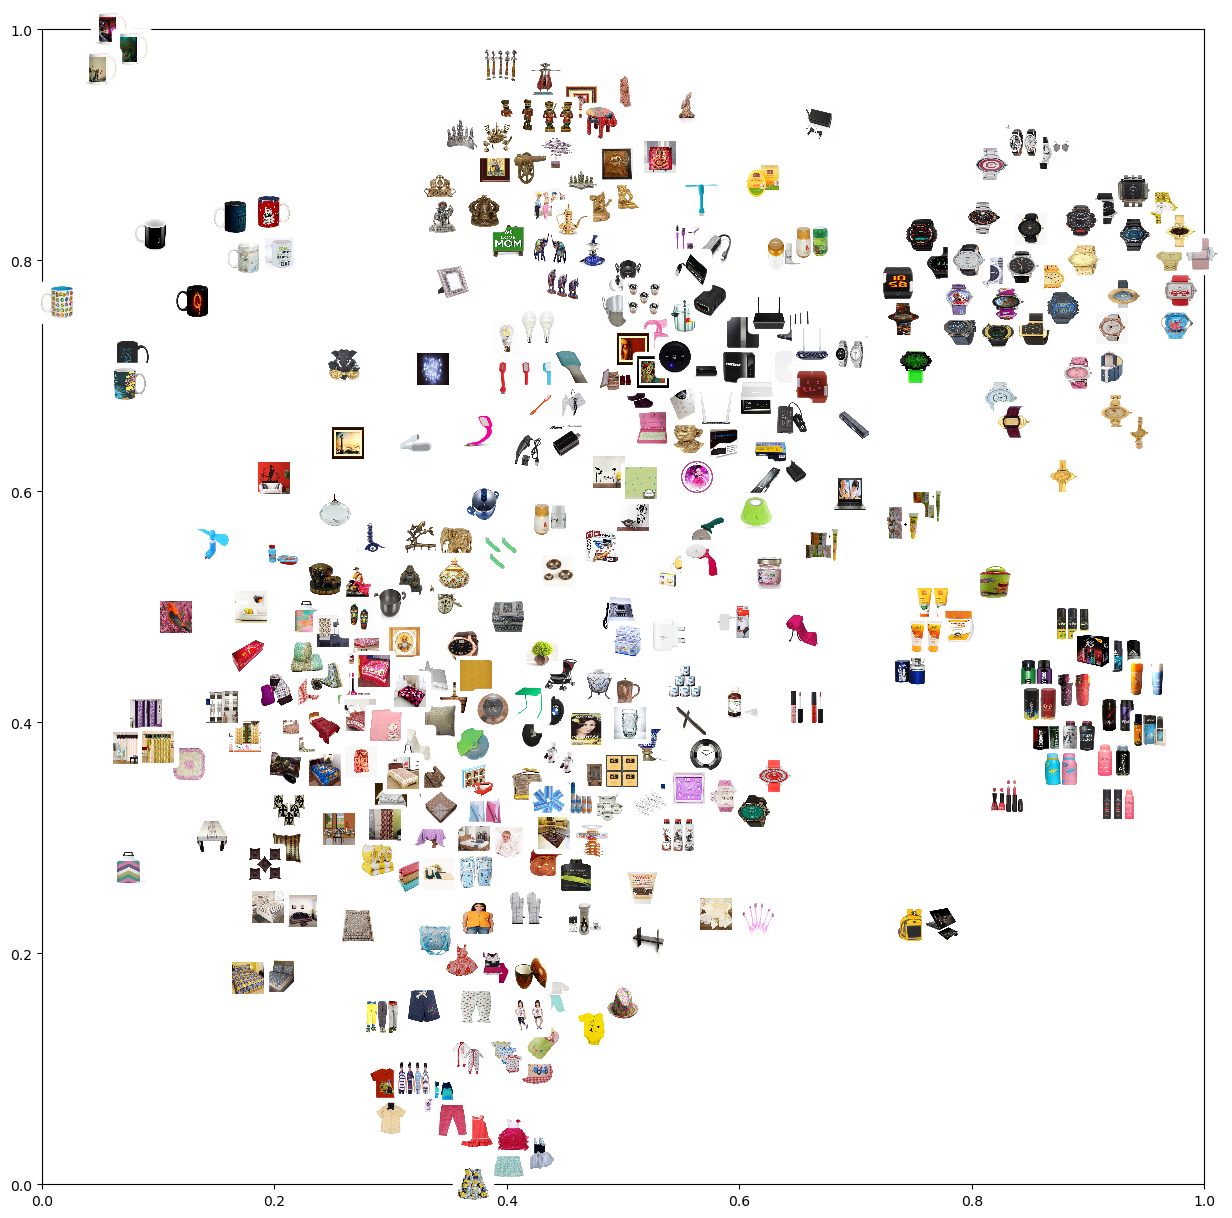

In [72]:
fc.plot_TSNE_images(X_tsne_cv, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retrouve des montres en haut à droite, des produits de beauté à droite, des produits pour bébé en bas, ou encore des mugs en haut à gauche et objets de décoration en haut. Au centre, les catégories sont effectivement très mélangées.

Visualisons désormais la réduction de dimension via une ACP.

In [47]:
pca = PCA()
pca.fit(cv_transform.toarray())

PCA()

In [48]:
pca.explained_variance_ratio_.cumsum()

array([0.06331886, 0.12043647, 0.16933621, ..., 1.        , 1.        ,
       1.        ])

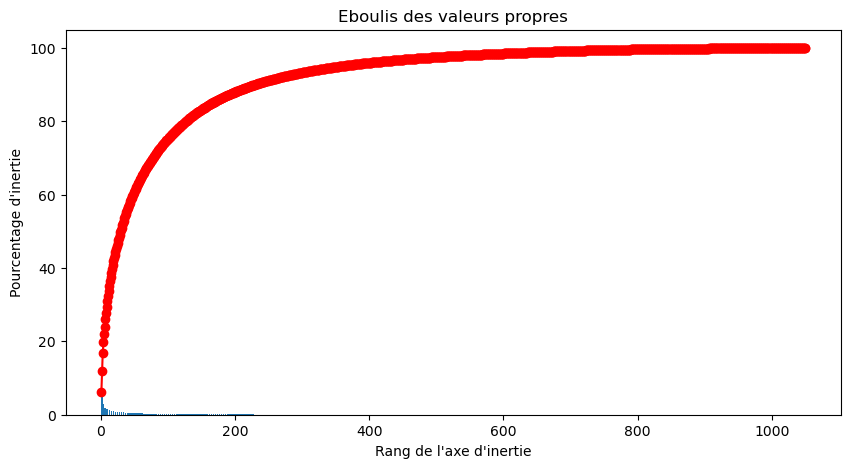

In [49]:
fc.eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 12% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [50]:
print("Dimensions dataset avant réduction PCA : ", cv_transform.toarray().shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(cv_transform.toarray())
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 5392)
Dimensions dataset après réduction PCA :  (1050, 666)


In [51]:
ARI_cv, X_tsne_cv, labels_cv = fc.ARI_fct_tsne(feat_pca, liste_cat, df_cat["label"])

ARI :  0.345 time :  6.0


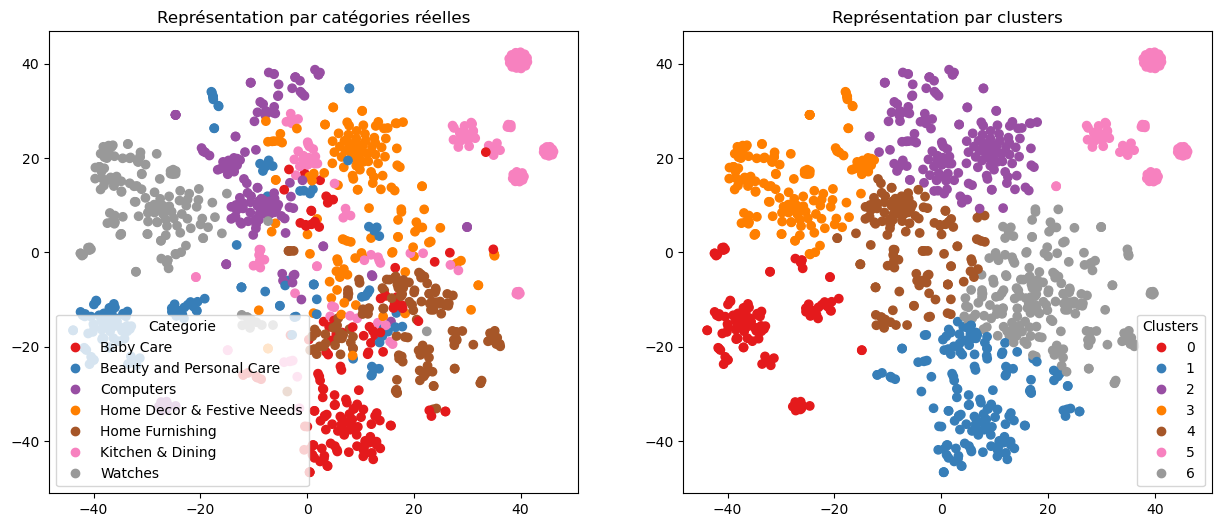

ARI :  0.345


In [52]:
fc.TSNE_visu_fct(X_tsne_cv, liste_cat, df_cat["label"], labels_cv, ARI_cv)

On obtient un ARI dégradé (0.345).

**Analyse par classes**

In [54]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_cv)
conf_mat

array([[ 94,   0,   1,  19,  17,  19,   0],
       [  1,   0,   0,  37,  15,   2,  95],
       [  0,   3,   0,  13, 117,   4,  13],
       [  3,   0,   2,  19,  89,  37,   0],
       [ 11,   0,   0,  12,   0, 127,   0],
       [  1,   0,  74,  30,  30,  13,   2],
       [  0, 137,   0,  11,   1,   1,   0]])

In [57]:
corresp = [0,6,5,3,2,4,1]
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_cv, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [0, 6, 5, 3, 2, 4, 1]
[[ 94   0  17  19  19   1   0]
 [  1  95  15  37   2   0   0]
 [  0  13 117  13   4   0   3]
 [  3   0  89  19  37   2   0]
 [ 11   0   0  12 127   0   0]
 [  1   2  30  30  13  74   0]
 [  0   0   1  11   1   0 137]]

              precision    recall  f1-score   support

           0       0.85      0.63      0.72       150
           1       0.86      0.63      0.73       150
           2       0.43      0.78      0.56       150
           3       0.13      0.13      0.13       150
           4       0.63      0.85      0.72       150
           5       0.96      0.49      0.65       150
           6       0.98      0.91      0.94       150

    accuracy                           0.63      1050
   macro avg       0.69      0.63      0.64      1050
weighted avg       0.69      0.63      0.64      1050



<Axes: >

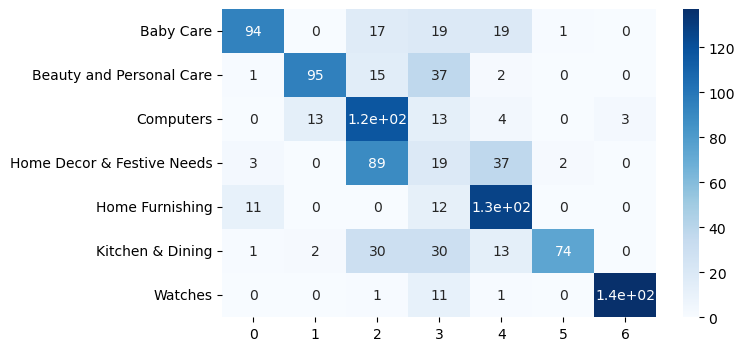

In [58]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 0 qui semble correspondre à *Baby Care* et la catégorie 6 à *Watches*.  

**Topic Modeling**

Le Topic Modeling (TM) consiste à trouver l’information contenue dans des documents textuels et de la présenter sous la forme de thèmes. C'est une technique non supervisée de classement de documents dans de multiples thèmes.

**LDA : Latent Dirichlet Allocation :**

Le modèle Latent Dirichlet Allocation (LDA) est un modèle probabiliste génératif qui permet de décrire des collections de documents de texte ou d’autres types de données discrètes. LDA fait partie d’une catégorie de modèles appelés “topic models”, qui cherchent à découvrir des structures thématiques cachées dans des vastes archives de documents.

Ceci permet d’obtenir des méthodes efficaces pour le traitement et l’organisation des documents de ces archives: organisation automatique des documents par sujet, recherche, compréhension et analyse du texte, ou même résumer des textes.

In [ ]:
n_topics = df_cat['cat_1'].nunique()

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        learning_method='online', 
        random_state=0)

# Fitter sur les données
lda.fit(cv_transform)

LatentDirichletAllocation(learning_method='online', n_components=7,
                          random_state=0)

In [ ]:
no_top_words = 10
fc.display_topics(lda, cv.get_feature_names_out(), no_top_words)

Topic 0:
baby cotton pack color fabric specification general girl package feature
Topic 1:
warranty skin type product laptop adapter hair replacement specification set
Topic 2:
buy delivery free cash genuine shipping product day guarantee replacement
Topic 3:
laptop sticker print skin pad wall mouse shape multicolor easy
Topic 4:
price showpiece home inch feature bowl product art color material
Topic 5:
mug ceramic perfect coffee gift design material tea loved safe
Topic 6:
usb light led power flexible portable fan port keyboard lamp


Nous allons analyser les différents topics trouvés afin de voir si des catégories semblent s'en dégager :
- Topic 0 : semble évoquer la catégorie *Baby Care*
- Topic 1 : semble mélanger plusieurs catégories comme *Beauty and Personal Care* et *Computers*.
- Topic 2 : aucune catégorie ne se dégage clairement.
- Topic 3 : semble évoquer la catégorie *Computers*.
- Topic 4 : semble évoquer une des catégories suivantes : *Home Decor & Festive Needs* ou *Home Furnishing*.
- Topic 5 : semble évoquer la catégorie *Kitchen & Dining*.
- Topic 6 : semble évoquer encore une fois la catégorie *Computers*.

**Topic Modeling**

**NMF (Non-Negative Matrix Factorisation):**

Une autre type de modélisation de sujet automatique non supervisée est NMF (Non-Negative Matrix Factorisation).

La NMF est utile pour réduire un jeu de données volumineux en attributs représentatifs. Elle permet de réduire les données volumineuses, par exemple des données texte, en représentations plus petites et plus sporadiques qui limitent la dimensionnalité des données.

In [ ]:
nmf = NMF(n_components=n_topics, random_state=0)
nmf.fit(cv_transform)

NMF(n_components=7, random_state=0)

In [ ]:
no_top_words = 10
fc.display_topics(nmf, cv.get_feature_names_out(), no_top_words)

Topic 0:
color feature material product pack inch type package box specification
Topic 1:
mug coffee perfect ceramic gift bring tea design loved material
Topic 2:
product free delivery cash genuine shipping buy day guarantee flipkart
Topic 3:
adapter warranty vgn vaio replacement power 19 smartpro laptop product
Topic 4:
skin laptop print shape mouse pad set inch combo warranty
Topic 5:
baby girl cotton fabric dress boy sleeve neck ideal pattern
Topic 6:
battery quality laptop lapguard replacement high cell including label product


Nous allons analyser les différents topics trouvés afin de voir si des catégories semblent s'en dégager :
- Topic 0 : aucune catégorie ne se dégage clairement.
- Topic 1 : semble évoquer la catégorie *Kitchen & Dining*.
- Topic 2 : aucune catégorie ne se dégage clairement.
- Topic 3 : semble évoquer la catégorie *Computers*.
- Topic 4 : semble évoquer encore une fois la catégorie *Computers*.
- Topic 5 : semble évoquer la catégorie *Baby Care*.
- Topic 6 : semble évoquer encore une fois la catégorie *Computers*.

### <a id="7"></a> 3.2.2 Tf-idf

Tf-idf (ou term frequency-inverse document frequency) est une technique de traitement de texte couramment utilisée pour évaluer l'importance relative d'un terme dans un document. Elle mesure la fréquence d'apparition d'un terme dans un document et l'inverse de la fréquence d'apparition du terme dans tous les documents d'une collection. En d'autres termes, plus un terme apparaît fréquemment dans un document donné et moins il apparaît dans l'ensemble de la collection, plus son poids Tf-idf est élevé.

Les paramètres max_df et min_df sont utilisés pour contrôler la sélection des mots à inclure dans la matrice de compte de termes générée par CountVectorizer. Ici, cela signifie que les mots présents dans plus de 95% des documents seront ignorés et les mots présents dans moins de 1 document seront ignorés.

In [11]:
tfv = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfv_fit = tfv.fit(df_cat[feat])
tfv_transform = tfv.transform(df_cat[feat])  

Afin de pouvoir visualiser nos données sur une représentation 2D, nous appliquons un TSNE à 2 composantes.

In [12]:
pickle.dump(tfv_transform, open('models/list_features_Tf-idf.pkl', 'wb'))

In [13]:
print("Tf-idf : ")
print("--------")
ARI_tfv, X_tsne_tfv, labels_tfv = fc.ARI_fct_tsne(tfv_transform, liste_cat, df_cat["label"])

Tf-idf : 
--------
ARI :  0.422 time :  6.0


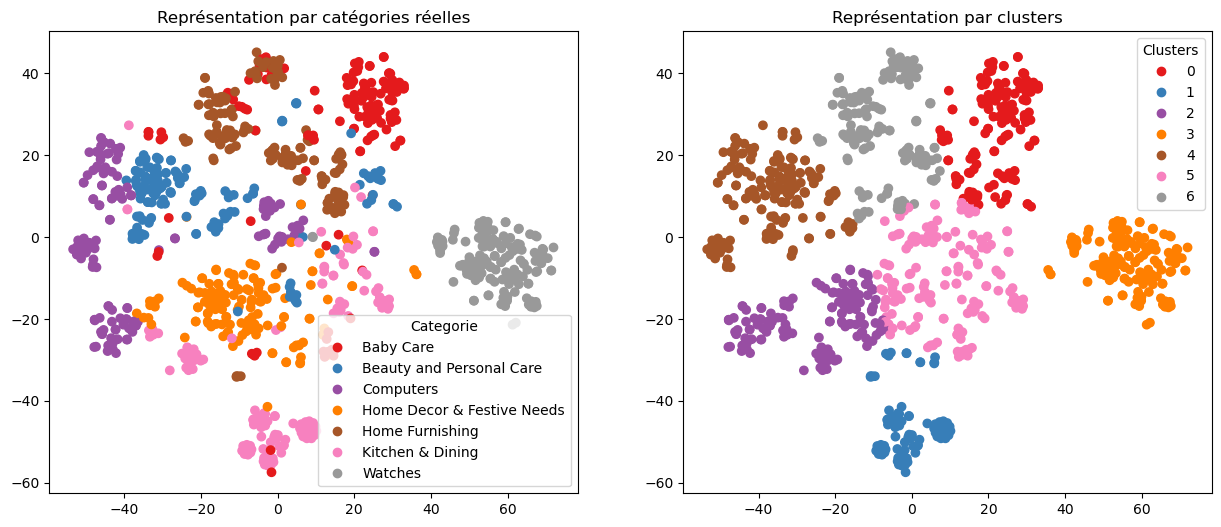

ARI :  0.422


In [55]:
fc.TSNE_visu_fct(X_tsne_tfv, liste_cat, df_cat["label"], labels_tfv, ARI_tfv)

On constate que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réélle. 
En effet, on constate que la plupart des catégories se mélangent plus dans la représentation réelle. 
D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme Watches.

Ici nous obtenons un ARI légèrement meilleur que pour le CountVectorizer à 0.422.

Visualisons la réduction de dimension via une ACP. 

In [61]:
pca = PCA()
pca.fit(tfv_transform.toarray())

PCA()

In [62]:
pca.explained_variance_ratio_.cumsum()

array([0.03458939, 0.059011  , 0.07789982, ..., 1.        , 1.        ,
       1.        ])

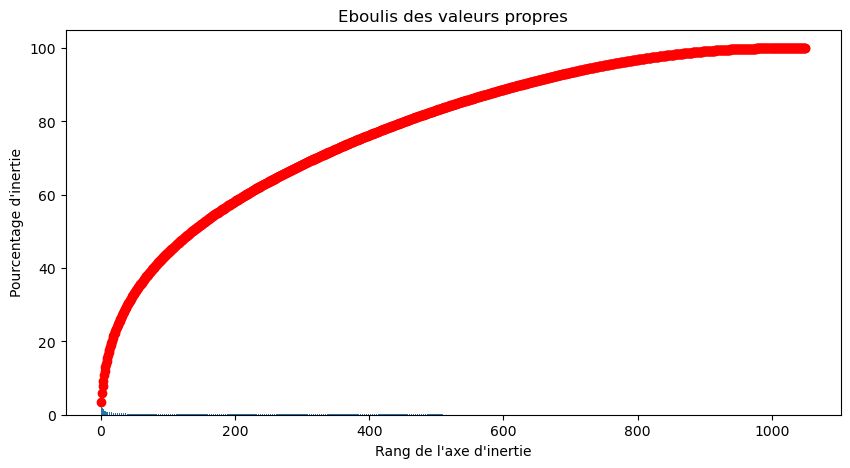

In [63]:
fc.eboulis(pca)

Les deux premières composantes de la PCA n'expliquent que 6% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

**Réduction de dimension ACP :**

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [64]:
print("Dimensions dataset avant réduction PCA : ", tfv_transform.toarray().shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(tfv_transform.toarray())
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 5392)
Dimensions dataset après réduction PCA :  (1050, 893)


In [65]:
ARI_tfv, X_tsne_tfv, labels_tfv = fc.ARI_fct_tsne(feat_pca, liste_cat, df_cat["label"])

ARI :  0.4288 time :  7.0


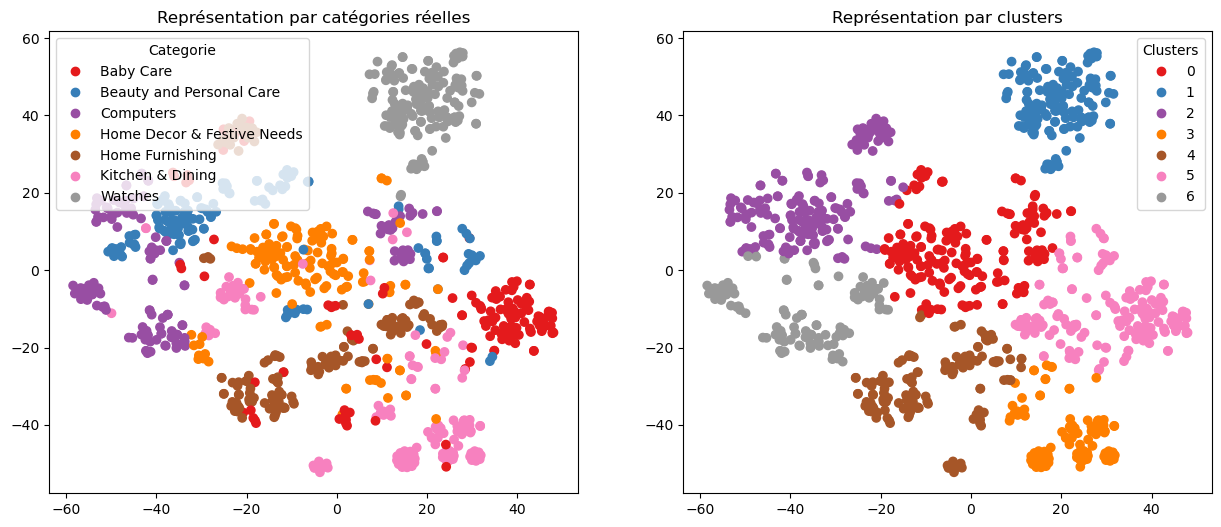

ARI :  0.4288


In [66]:
fc.TSNE_visu_fct(X_tsne_tfv, liste_cat, df_cat["label"], labels_tfv, ARI_tfv)

On obtient une légère amélioration de l'ARI (0.4288) après avoir effectué une réduction de dimension via ACP puis une projection TSNE à 2 composantes.

On constate cependant toujours que les clusters ont séparé les différentes catégories de manière plus simplifiée que leur représentation réelle. La plupart des catégories se mélangent plus dans la représentation réelle. D'autres clusters semblent un peu mieux déterminés, ce sont les catégories qui semblent les plus espacées dans la représentation réelle comme *Watches*.

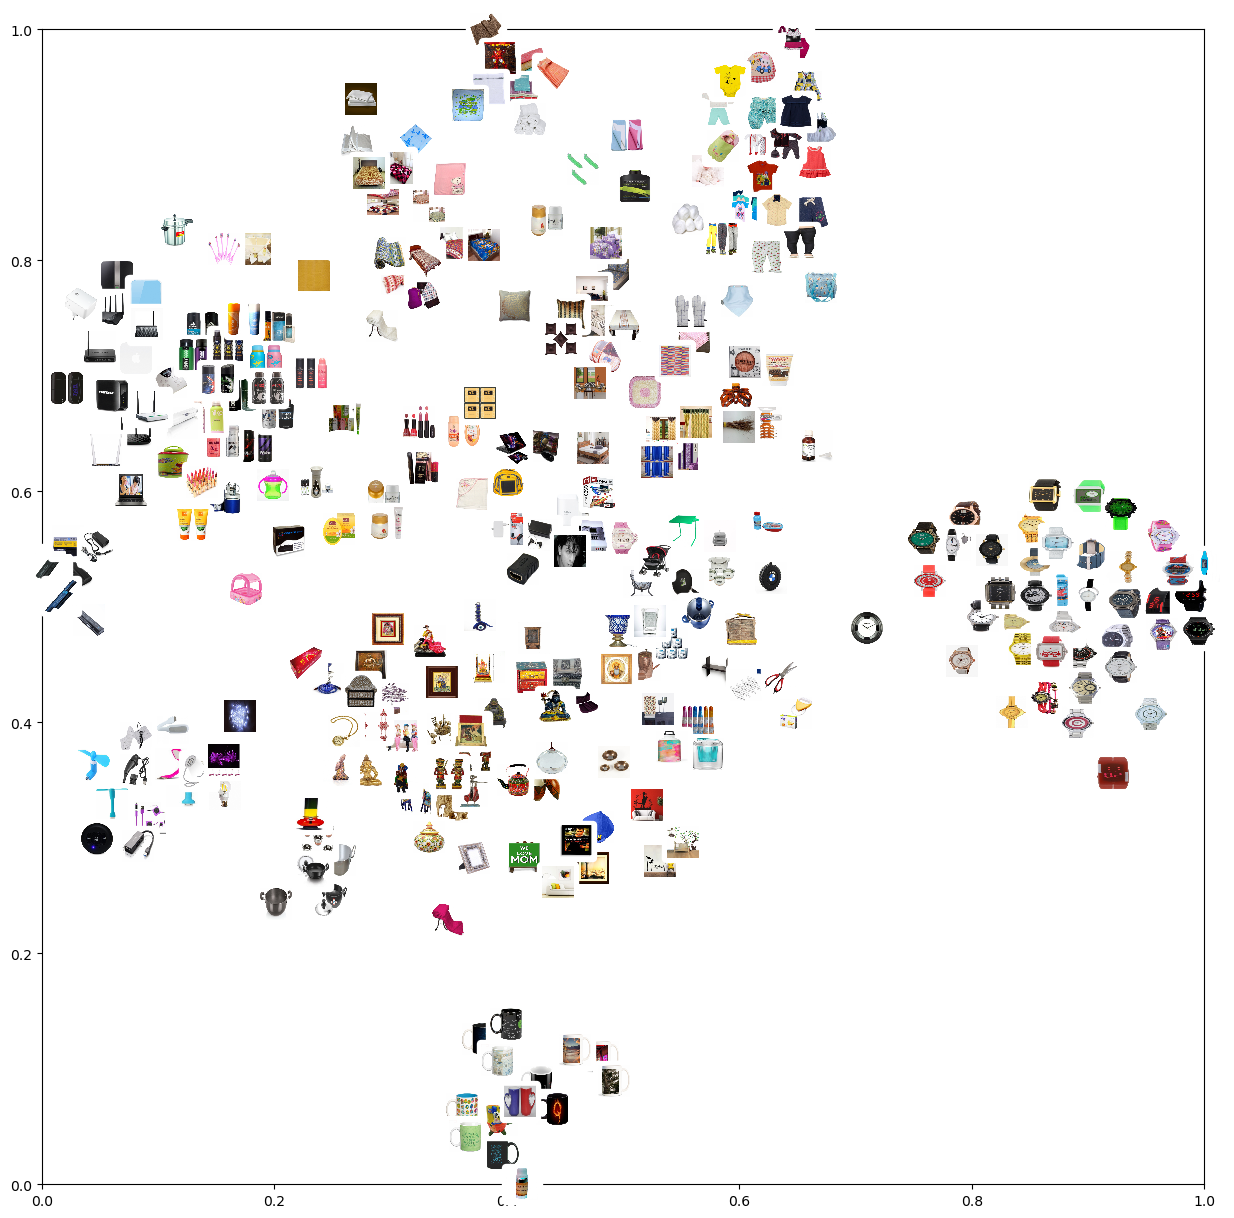

In [78]:
fc.plot_TSNE_images(X_tsne_tfv, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate que certaines catégories sont bien regroupées et séparées à certains endroits. Par exemple, on retouve des montres à droite, des produits pour bébés en haut, du matériel électronique à droite, ainsi que des produits de beauté, et enfin du matériel de cuisine en bas. Au centre, les catégories semblent encore une fois mélangées.

**Analyse par classes**

In [79]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_tfv)
conf_mat

array([[  6,   0,  19,   3,  21,  98,   3],
       [ 27,   0,  93,   0,   2,  25,   3],
       [ 34,   0,  45,   0,   0,   0,  71],
       [111,   0,   3,   7,  12,   6,  11],
       [  1,   0,  24,   0,  92,  33,   0],
       [  7,   0,   2,  91,  10,  10,  30],
       [  2, 148,   0,   0,   0,   0,   0]])

In [80]:
corresp = [0,6,5,3,2,4,1]
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_cv, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [0, 6, 5, 3, 2, 4, 1]
[[ 94   0  17  19  19   1   0]
 [  1  95  15  37   2   0   0]
 [  0  13 117  13   4   0   3]
 [  3   0  89  19  37   2   0]
 [ 11   0   0  12 127   0   0]
 [  1   2  30  30  13  74   0]
 [  0   0   1  11   1   0 137]]

              precision    recall  f1-score   support

           0       0.85      0.63      0.72       150
           1       0.86      0.63      0.73       150
           2       0.43      0.78      0.56       150
           3       0.13      0.13      0.13       150
           4       0.63      0.85      0.72       150
           5       0.96      0.49      0.65       150
           6       0.98      0.91      0.94       150

    accuracy                           0.63      1050
   macro avg       0.69      0.63      0.64      1050
weighted avg       0.69      0.63      0.64      1050



<Axes: >

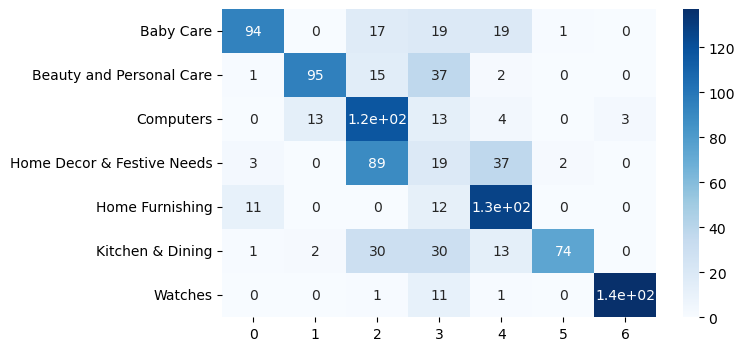

In [81]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (7,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

On constate qu'il existe des erreurs pour certains clusters mais d'autres semblent assez bien correspondre aux catégories, comme c'est le cas pour le cluster 0 qui semble correspondre à *Baby Care*, la catégorie 6 à *Watches* et la catégorie 5 à *Kitchen & Dining*. 

**Topic Modeling**

**LDA : Latent Dirichlet Allocation :**

In [ ]:
n_topics = df_cat['cat_1'].nunique()

# Créer le modèle LDA
lda = LatentDirichletAllocation(
        n_components=n_topics, 
        learning_method='online', 
        random_state=0)

# Fitter sur les données
lda.fit(tfv_transform)

LatentDirichletAllocation(learning_method='online', n_components=7,
                          random_state=0)

In [ ]:
no_top_words = 10
fc.display_topics(lda, tfv.get_feature_names_out(), no_top_words)

Topic 0:
skin baby laptop pack cotton print girl polyester shape color
Topic 1:
usb warranty power adapter battery bowl light laptop fan flexible
Topic 2:
com flipkart cash genuine shipping delivery buy free product guarantee
Topic 3:
lunch bella franck cranberry fb127a fb74c cutting fast sweetness everytime
Topic 4:
prithish ceramic mug canon independence 175 225 shoppingtara nehp pair
Topic 5:
mug ceramic coffee gift perfect design rockmantra safe material loved
Topic 6:
nail lipstick polish rythmx opener exchange mattress important arnavs multi1


Nous allons analyser les différents topics trouvés afin de voir si des catégories semblent s'en dégager :
- Topic 0 : semble évoquer la catégorie *Baby Care*.
- Topic 1 : semble évoquer la catégorie *Computers*.
- Topic 2 : aucune catégorie ne se dégage clairement.
- Topic 3 : aucune catégorie ne se dégage clairement.
- Topic 4 : semble évoquer la catégorie *Kitchen & Dining*.
- Topic 5 : semble évoquer la catégorie *Kitchen & Dining*.
- Topic 6 : semble évoquer la catégorie *Beauty and Personal Care*.

**Topic Modeling**

**NMF (Non-Negative Matrix Factorisation):**

In [ ]:
nmf = NMF(n_components=n_topics, random_state=0)
nmf.fit(tfv_transform)

NMF(n_components=7, random_state=0)

In [ ]:
no_top_words = 10
fc.display_topics(nmf, tfv.get_feature_names_out(), no_top_words)

Topic 0:
com flipkart cash genuine shipping delivery buy free product set
Topic 1:
mug coffee ceramic perfect tea printland prithish bring gift presented
Topic 2:
baby girl fabric cotton dress sleeve boy neck shirt pattern
Topic 3:
watch analog men discount woman india great dial strap rs
Topic 4:
rockmantra ceramic mug thrilling crafting porcelain permanent ensuring stay start
Topic 5:
laptop skin warranty inch shape multicolor print pack color model
Topic 6:
showpiece best rs guarantee replacement online day price shipping genuine


Nous allons analyser les différents topics trouvés afin de voir si des catégories semblent s'en dégager :
- Topic 0 : aucune catégorie ne se dégage clairement.
- Topic 1 : semble évoquer la catégorie *Kitchen & Dining*.
- Topic 2 : semble évoquer la catégorie *Baby Care*.
- Topic 3 : semble évoquer la catégorie *Watches*.
- Topic 4 : semble évoquer la catégorie *Kitchen & Dining*.
- Topic 5 : semble évoquer la catégorie *Computers*.
- Topic 6 : aucune catégorie ne se dégage clairement.

# <a id="8"></a> 4. Traitement des données visuelles

In [37]:
df_cat = pd.read_csv('data_text_clean.csv')

In [14]:
path_images = "Flipkart/Images/"
list_photos = [file for file in listdir(path_images)]
print(len(list_photos))

1050


In [12]:
df_cat.groupby("label")['image'].count()

label
0    150
1    150
2    150
3    150
4    150
5    150
6    150
Name: image, dtype: int64

In [6]:
df_cat.head()

Unnamed: 0                           uniq_id            crawl_timestamp  \
0           0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56+00:00   
1           1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56+00:00   
2           2  64d5d4a258243731dc7bbb1eef49ad74  2016-04-30 03:22:56+00:00   
3           3  d4684dcdc759dd9cdf41504698d737d8  2016-06-20 08:49:52+00:00   
4           4  6325b6870c54cd47be6ebfbffa620ec7  2016-06-20 08:49:52+00:00   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   
2  http://www.flipkart.com/eurospa-cotton-terry-f...   
3  http://www.flipkart.com/santosh-royal-fashion-...   
4  http://www.flipkart.com/jaipur-print-cotton-fl...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   
2                Eurospa Cotton Terry Face Towel Set   
3  SANTOSH ROYAL FASHION Cotton Printed King size...   
4  Jaipur Print Cotton Floral King sized Double B...   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   
2  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEG6SHXTDB2A2Y   
3  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJT9UQWHDUBH4   
4  ["Home Furnishing >> Bed Linen >> Bedsheets >>...  BDSEJTHNGWVGWWQU   

   retail_price  discounted_price                                 image  ...  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg  ...   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg  ...   
2           NaN               NaN  64d5d4a258243731dc7bbb1eef49ad74.jpg  ...   
3        2699.0            1299.0  d4684dcdc759dd9cdf41504698d737d8.jpg  ...   
4        2599.0             698.0  6325b6870c54cd47be6ebfbffa620ec7.jpg  ...   

              cat_3 label                                          descr_bow  \
0          Curtains     4  key features elegance polyester multicolor abs...   
1  Baby Bath Towels     0  specifications sathiyas cotton bath towel bath...   
2  Baby Bath Towels     0  key features eurospa cotton terry face towel s...   
3         Bedsheets     4  key features santosh royal fashion cotton prin...   
4         Bedsheets     4  key features jaipur print cotton floral king s...   

  length_bow                                      descr_bow_lem  \
0        156  key feature elegance polyester multicolor abst...   
1         63  specification sathiyas cotton bath towel bath ...   
2        158  key feature eurospa cotton terry face towel se...   
3        114  key feature santosh royal fashion cotton print...   
4        156  key feature jaipur print cotton floral king si...   

  length_bow_lem                                     descr_bow_stem  \
0            156  key featur eleg polyest multicolor abstract ey...   
1             63  specif sathiya cotton bath towel bath towel re...   
2            158  key featur eurospa cotton terri face towel set...   
3            114  key featur santosh royal fashion cotton print ...   
4            156  key featur jaipur print cotton floral king siz...   

  length_bow_stem                                           descr_dl  \
0             156  key features of elegance polyester multicolor ...   
1              63  specifications of sathiyas cotton bath towel (...   
2             158  key features of eurospa cotton terry face towe...   
3             114  key features of santosh royal fashion cotton p...   
4             156  key features of jaipur print cotton floral kin...   

   length_dl  
0        248  
1         84  
2        253  
3        151  
4        232  

[5 rows x 28 columns]

Catégorie : Baby Care


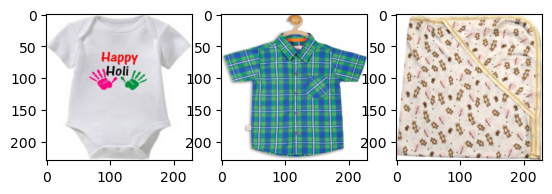

Catégorie : Beauty and Personal Care


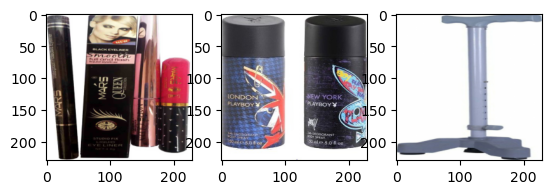

Catégorie : Computers


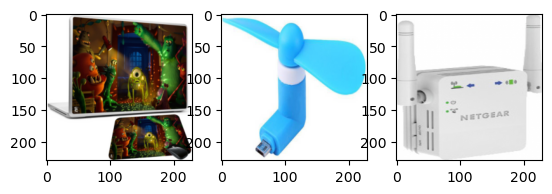

Catégorie : Home Decor & Festive Needs


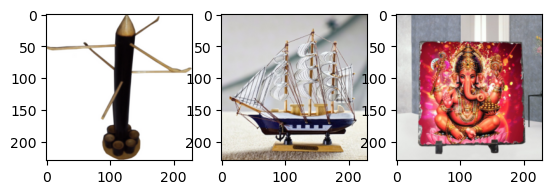

Catégorie : Home Furnishing


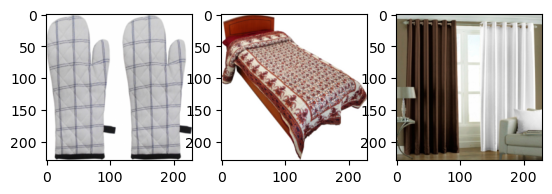

Catégorie : Kitchen & Dining


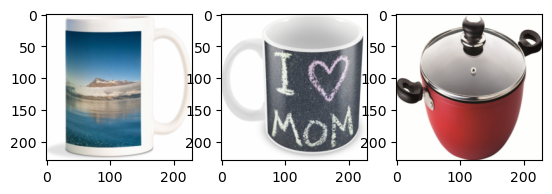

Catégorie : Watches


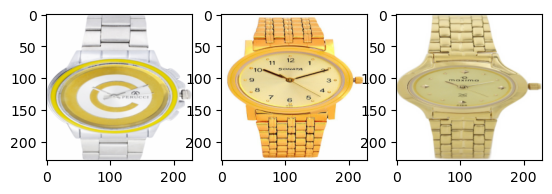

In [7]:
df_img = df_cat.groupby('cat_1')['image']

for name, img in df_img:
        files = list(img.sample(3))
        print('Catégorie :', name)
        for i in range(3):
            plt.subplot(130 + 1 + i)
            filename = path_images + files[i]
            image = imread(filename)
            image = resize(image, (230, 230)) 
            plt.imshow(image)
            
        plt.show()

## <a id="9"></a> 4.1 Transformation des images

In [15]:
def display(imglist,size):
    cols = len(imglist)
    fig = plt.figure(figsize=(size*cols,size*cols))
    for i in range(0,cols):
        a = fig.add_subplot(1, cols, i+1)
        subfig = plt.imshow(imglist[i], cmap='gray')
        #plt.get_cmap('gray')
        subfig.axes.get_xaxis().set_visible(False)
        subfig.axes.get_yaxis().set_visible(False)

On effectue et affiche plusieurs transformations sur les images : un passage en gris, l'égalisation des histogrammes et l'élimination du bruit. 

In [14]:
# Image initiale
image1 = cv2.imread(path_images+list_photos[1])

# Image convertie en gris
image2 = cv2.imread(path_images+list_photos[1],0)
#image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)

# Image égalisée
image3 = cv2.equalizeHist(image2)

# Image débruitée
image4 = cv2.GaussianBlur(image3, (5, 5), 0)

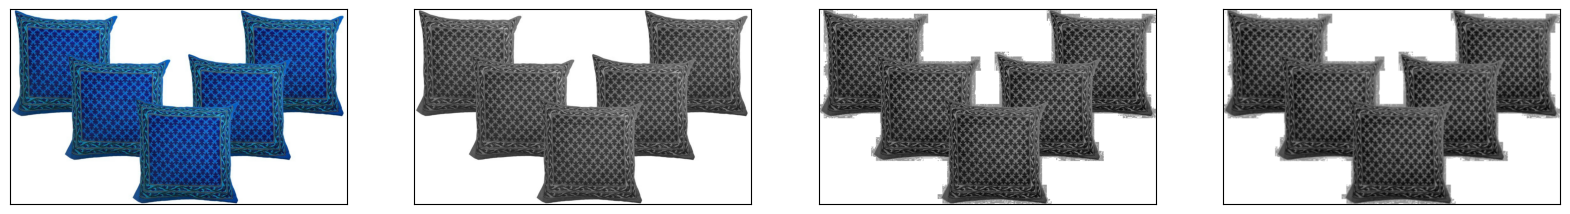

In [15]:
display([image1,image2,image3, image4],5)

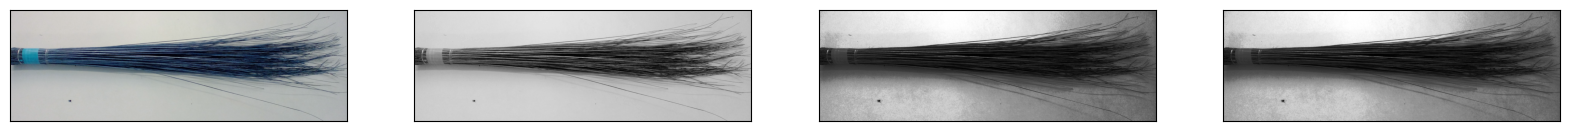

In [16]:
image1 = cv2.imread(path_images+list_photos[0])
image2 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
image3 = cv2.equalizeHist(image2)
image4 = cv2.GaussianBlur(image3, (5, 5), 0)

display([image1,image2,image3, image4],5)

## <a id="10"></a> 4.2 Méthode SIFT

La méthode SIFT (Scale-Invariant Feature Transform) est une technique qui permet de détecter des points d'intérêt dans une image et de les décrire de manière robuste et invariante à l'échelle.

### <a id="11"></a> 4.2.1 Création des descripteurs de chaque image


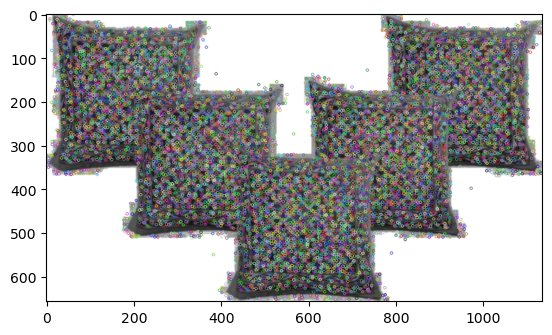

Descripteurs :  (12813, 128)



In [16]:
sift = cv2.SIFT_create()
image = cv2.imread(path_images+list_photos[1],0)
image = cv2.equalizeHist(image)
image = cv2.GaussianBlur(image, (5, 5), 0)
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)
plt.imshow(img)
plt.show()
print("Descripteurs : ", des.shape)
print()

Nous testons et affichons tout d'abord avec 1 image. On constate que l'image contient 12 813 descripteurs et chaque descripteur est un vecteur de longueur 128.

Nous allons maintenant l'appliquer à chaque image. Nous transformons chacune d'entre elles et créons une liste de descripteurs par image ainsi qu'une liste de descripteur pour l'ensemble des images.

In [17]:
sift_keypoints = []
temps1=time.time()
sift = cv2.SIFT_create()

for image_num in range(len(df_cat['image'])) :
    image = cv2.imread(path_images+df_cat['image'][image_num],0)
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = cv2.equalizeHist(image)
    image = cv2.GaussianBlur(image, (5, 5), 0)
    kp, des = sift.detectAndCompute(image, None)
    sift_keypoints.append(des)

sift_keypoints_img = np.asarray(sift_keypoints, dtype=object)
sift_keypoints_all = np.concatenate(sift_keypoints_img, axis=0)

print("Nombre de descripteurs : ", sift_keypoints_all.shape)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Nombre de descripteurs :  (6679615, 128)
Temps de traitement : 329.35 secondes


Nous obtenons 6 679 615 descripteurs pour 1 050 images soit en moyenne 6 361 par image.

### <a id="12"></a> 4.2.2 Création des clusters de descripteurs

Le choix est fait d'utiliser ici *MiniBatchKMeans* afin d'obtenir des temps de traitement raisonnables.

In [18]:
temps1=time.time()

# k déterminé comme étant la racine carrée du nombre total de descripteurs.
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs.")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Nombre de clusters estimés :  2584
Création de 2584 clusters de descripteurs.


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Temps de traitement : 203.82 secondes


Avec la méthode consistant à déterminer le nombre de clusters comme étant égale à la racine carrée du nombre total de descripteurs, nous obtenons 2584 clusters pour séparer/regrouper nos descripteurs.

### <a id="13"></a> 4.2.3 Création des features des images

Pour chaque image, nous allons prédire le numéro de cluster de chaque descripteur et ainsi construire un histogramme pour chaque image (comptant le nombre de ses descripteurs par cluster). L'histogramme d'une image correspond aux features de l'image.

In [19]:
def build_histogram(kmeans, des, image_num):
    '''Construit un histogramme comptant pour une image du nombre de descripteurs par cluster.'''
    
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [20]:
temps1=time.time()
hist_vec=[]

for i, image_desc in enumerate(sift_keypoints_img) :
    # Calcule l'histogramme
    hist = build_histogram(kmeans, image_desc, i)
    hist_vec.append(hist)

img_features = np.asarray(hist_vec)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Temps de traitement : 57.35 secondes


In [21]:
img_features.shape

(1050, 2584)

In [22]:
pickle.dump(img_features, open('models/list_features_SIFT.pkl', 'wb'))

### <a id="14"></a> 4.2.4 Réduction de dimension

Nous réalisons tout d'abord un TSNE avec 2 composantes afin d'avoir une visualisation 2D.

In [23]:
ARI_sift, X_tsne_sift, labels_sift = fc.ARI_fct_tsne(img_features, liste_cat, df_cat["label"])

ARI :  0.0592 time :  8.0


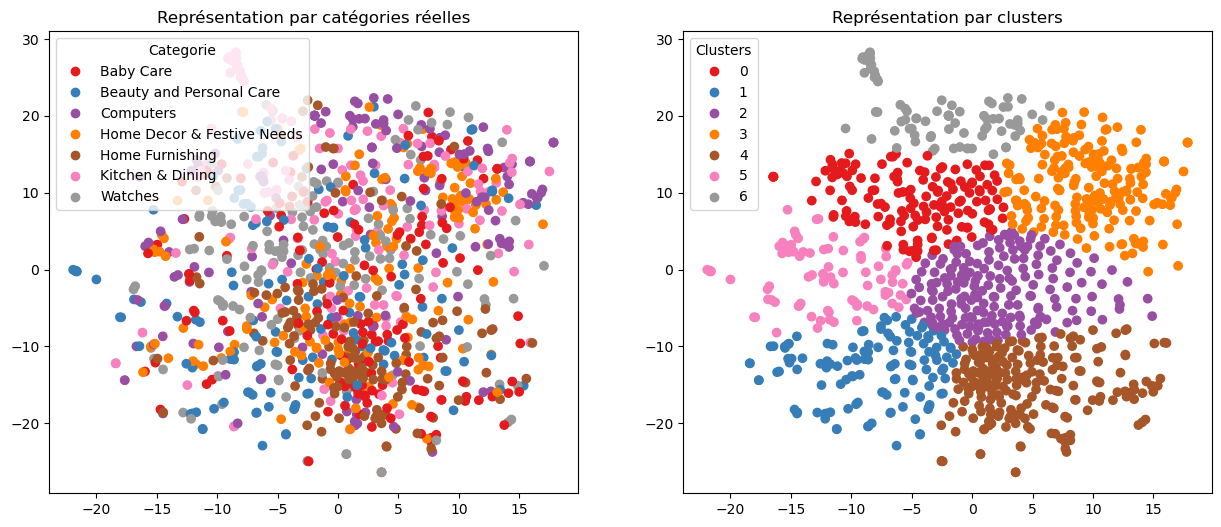

ARI :  0.0592


In [29]:
fc.TSNE_visu_fct(X_tsne_sift, liste_cat, df_cat["label"], labels_sift, ARI_sift)

Nous obtenons une ARI très faible (0.0592).

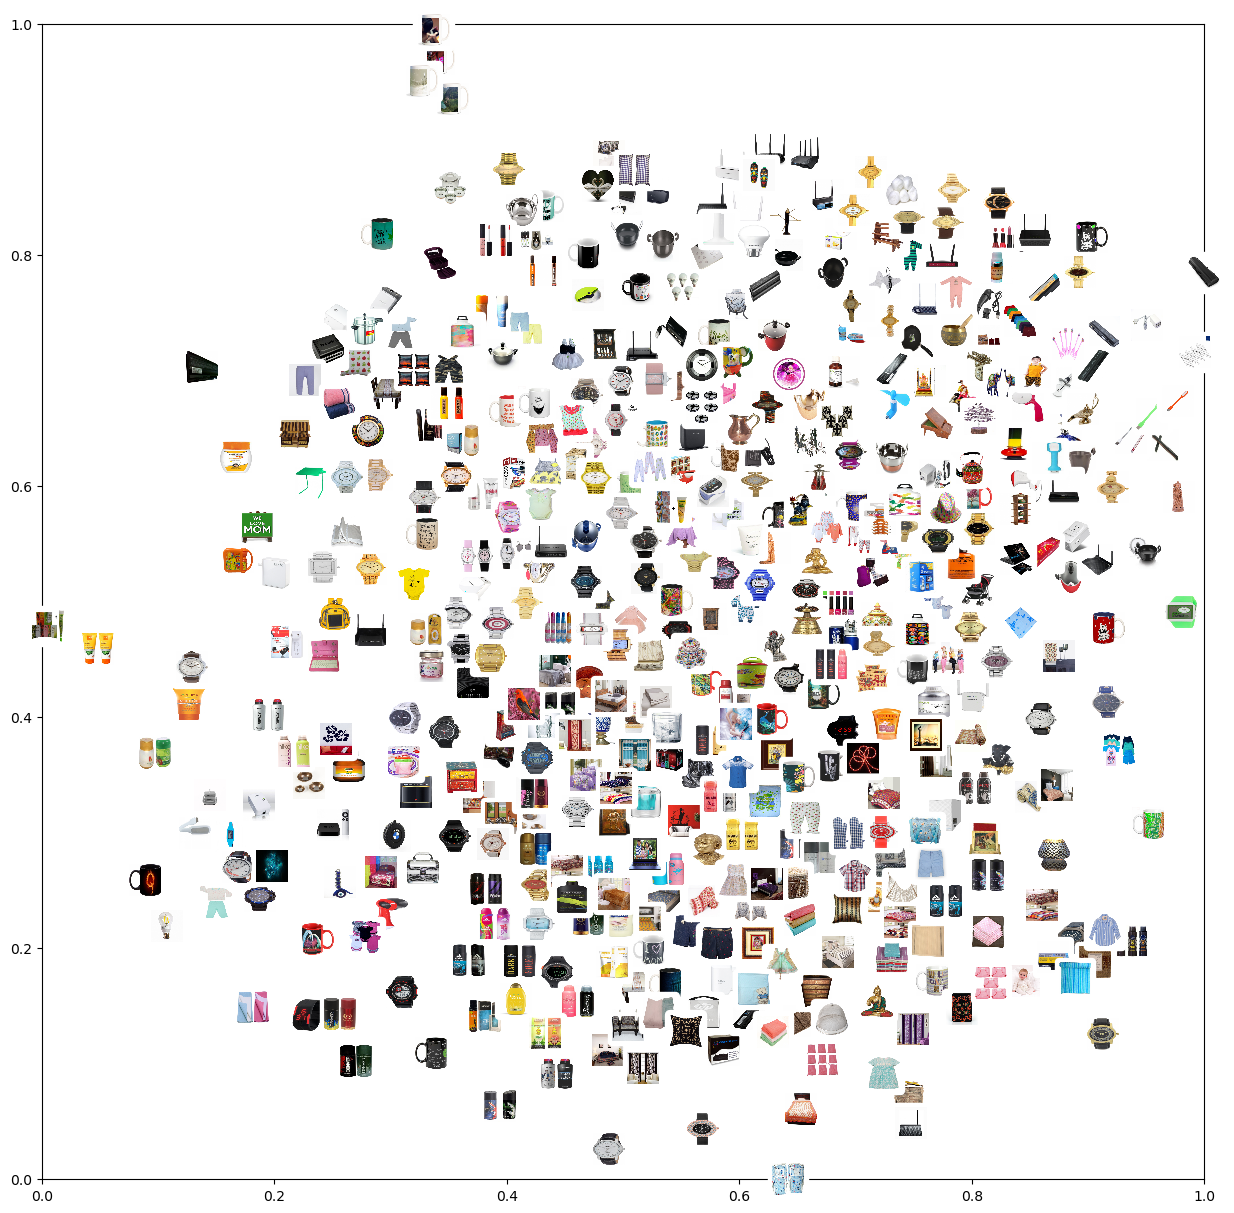

In [79]:
fc.plot_TSNE_images(X_tsne_sift, df_cat, path_images)

On affiche une partie des images sur la visualisation 2D avec les données TSNE calculées précédemment. On constate qu'il est ici difficile de discerner des regroupements de catégories. Celles-ci sont toutes mélangées.

Visualisons désormais la réduction de dimension via une ACP.

In [30]:
pca = PCA()
pca.fit(img_features)

PCA()

In [31]:
pca.explained_variance_ratio_.cumsum()

array([0.07209636, 0.13014189, 0.17292995, ..., 1.        , 1.        ,
       1.        ])

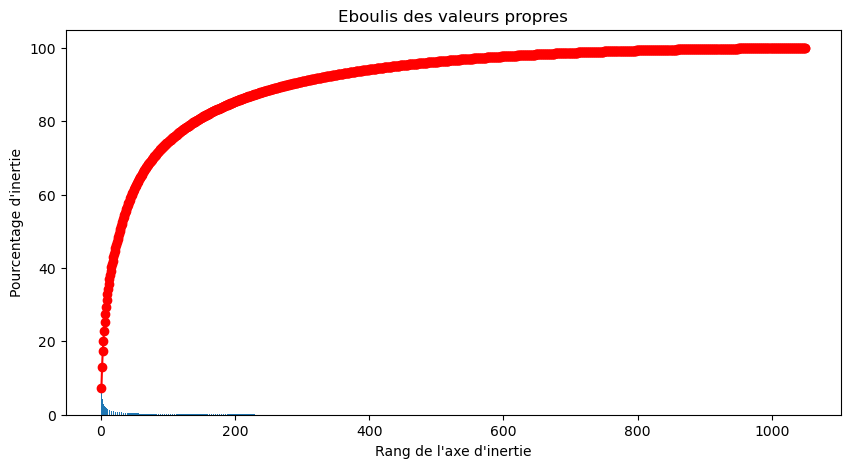

In [32]:
fc.eboulis(pca)

Les 2 premières composantes principales de l'ACP ne représentent que 13% de la variance expliquée. Nous perdrions beaucoup d'information si nous décidions de n'utiliser que ces 2 premières composantes.

Nous allons donc réaliser une ACP afin de réduire nos dimensions puis ensuite réaliser un TSNE sur cette réduction.

La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%).
L'intérêt est ici d'avoir une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE.

In [33]:
print("Dimensions dataset avant réduction PCA : ", img_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(img_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 2584)
Dimensions dataset après réduction PCA :  (1050, 741)


In [34]:
ARI_sift, X_tsne_sift, labels_sift = fc.ARI_fct_tsne(feat_pca, liste_cat, df_cat["label"])

ARI :  0.0488 time :  6.0


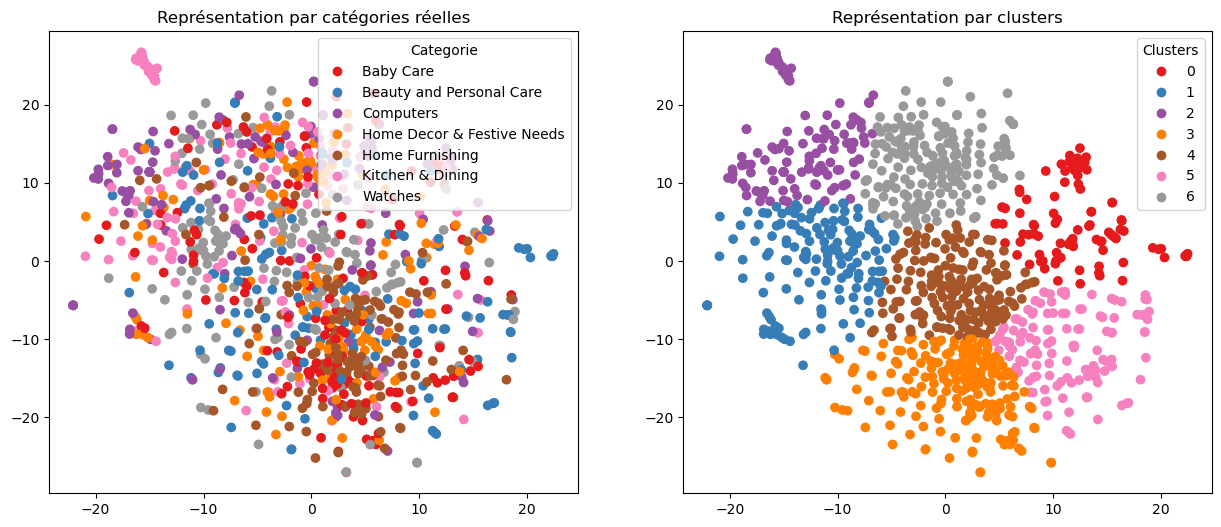

ARI :  0.0488


In [35]:
fc.TSNE_visu_fct(X_tsne_sift, liste_cat, df_cat["label"], labels_sift, ARI_sift)

On obtient un ARI dégradé (0.0488).

### <a id="15"></a> 4.2.5 Analyse par classes

Nous réalisons une matrice de confusion.

In [37]:
df_tsne = pd.DataFrame(X_tsne_sift[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df_cat["label"]
df_tsne["class_name"] = df_cat["cat_1"]
df_tsne["cluster"] = labels_sift

In [48]:
conf_mat = metrics.confusion_matrix(df_cat["label"], labels_sift)
conf_mat

array([[24,  8, 30, 22, 56, 10,  0],
       [22, 41, 23, 16, 20, 20,  8],
       [21, 14,  9, 51, 14, 16, 25],
       [ 6, 22, 35, 46, 24, 11,  6],
       [ 7, 13, 37,  5, 75,  6,  7],
       [29,  8, 25, 34,  8,  7, 39],
       [41, 20, 30, 21, 15, 19,  4]])

In [50]:
corresp = [6,1,4,2,0,3,5]
cls_labels_transform = fc.conf_mat_transform(df_cat["label"], labels_sift, corresp)
conf_mat = metrics.confusion_matrix(df_cat["label"], cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(df_cat["label"], cls_labels_transform))

Correspondance des clusters :  [6, 1, 4, 2, 0, 3, 5]
[[56  8 22 10 30  0 24]
 [20 41 16 20 23  8 22]
 [14 14 51 16  9 25 21]
 [24 22 46 11 35  6  6]
 [75 13  5  6 37  7  7]
 [ 8  8 34  7 25 39 29]
 [15 20 21 19 30  4 41]]

              precision    recall  f1-score   support

           0       0.26      0.37      0.31       150
           1       0.33      0.27      0.30       150
           2       0.26      0.34      0.30       150
           3       0.12      0.07      0.09       150
           4       0.20      0.25      0.22       150
           5       0.44      0.26      0.33       150
           6       0.27      0.27      0.27       150

    accuracy                           0.26      1050
   macro avg       0.27      0.26      0.26      1050
weighted avg       0.27      0.26      0.26      1050



<Axes: >

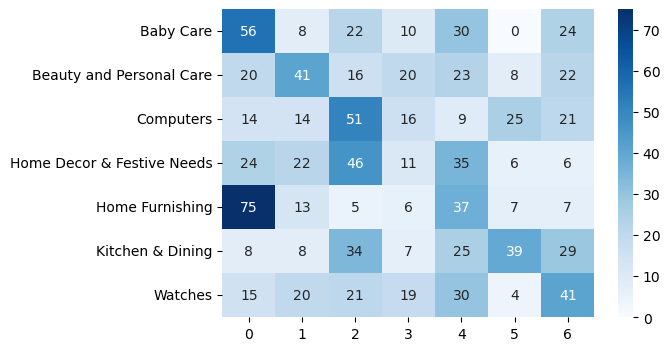

In [51]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

La matrice de confusion ne donne pas de clustering évident. C'est cohérent puisque les scores sont faibles pour ce modèle.

### <a id="16"></a> 4.2.6 Autre méthode de détermination du nombre de clusters

Précédemment, nous avons utilisé la méthode consistant à déterminer le nombre de clusters comme étant égale à la racine carrée du nombre total de descripteurs. Désormais nous allons tester une seconde méthode consistant à définir k comme étant égale au nombre de catégorie fois 10, soit ici 7x10 = 70 clusters.

In [12]:
temps1=time.time()

# k déterminé comme étant le nombre de catégorie recherchée fois 10.
k = len(liste_cat)*10
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs.")

# Clustering
kmeans2 = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans2.fit(sift_keypoints_all)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Nombre de clusters estimés :  70
Création de 70 clusters de descripteurs.


/Users/oceaneyouyoutte/miniconda3/envs/tensorflow/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Temps de traitement : 13.77 secondes


In [15]:
temps1=time.time()
hist_vec2=[]

for i, image_desc in enumerate(sift_keypoints_img) :
    # Calcule l'histogramme
    hist = build_histogram(kmeans2, image_desc, i)
    hist_vec2.append(hist)

img_features2 = np.asarray(hist_vec2)

temps2 = np.round(time.time()-temps1, 2)
print("Temps de traitement : {} secondes".format(temps2))

Temps de traitement : 3.86 secondes


In [25]:
ARI_sift2, X_tsne_sift2, labels_sift2 = fc.ARI_fct_tsne(img_features2, liste_cat, df_cat["label"])

ARI :  0.0599 time :  8.0


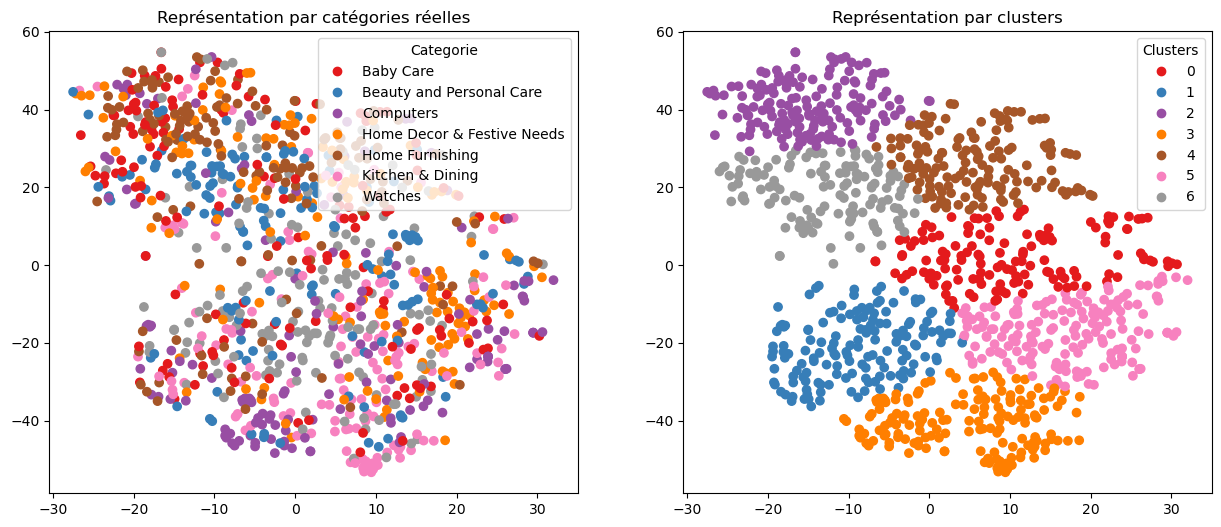

ARI :  0.0599


In [17]:
fc.TSNE_visu_fct(X_tsne_sift2, liste_cat, df_cat["label"], labels_sift2, ARI_sift2)

Les résultats sont du même ordre de grandeur que la méthode précédente mais sont légèrement meilleurs.

In [18]:
print("Dimensions dataset avant réduction PCA : ", img_features2.shape)
pca = PCA(n_components=0.99)
feat_pca2 = pca.fit_transform(img_features2)
print("Dimensions dataset après réduction PCA : ", feat_pca2.shape)

Dimensions dataset avant réduction PCA :  (1050, 70)
Dimensions dataset après réduction PCA :  (1050, 48)


In [19]:
ARI_sift2, X_tsne_sift2, labels_sift2 = fc.ARI_fct_tsne(feat_pca2, liste_cat, df_cat["label"])

ARI :  0.0511 time :  7.0


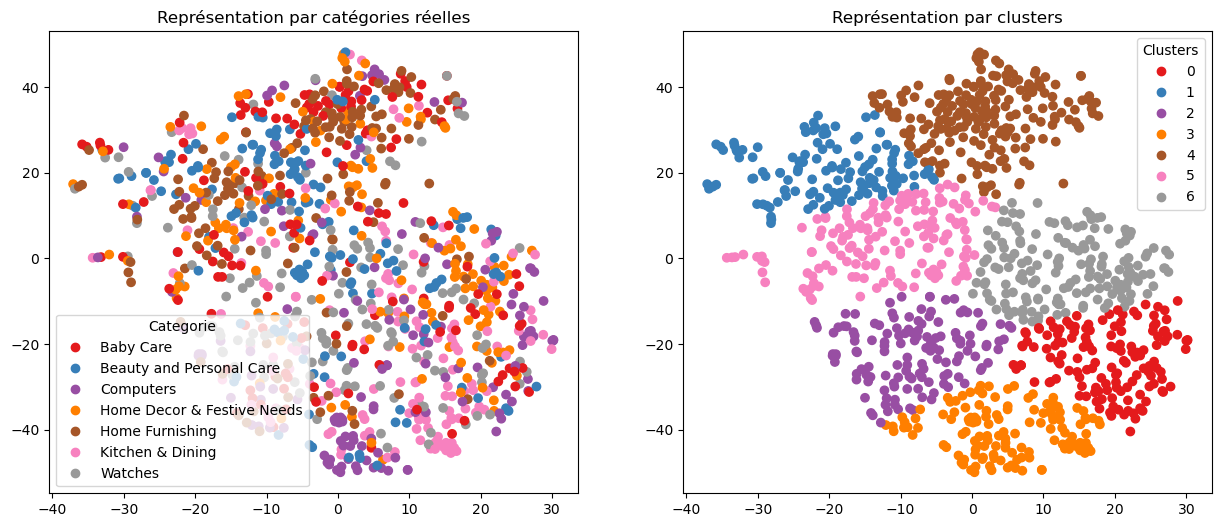

ARI :  0.0511


In [20]:
fc.TSNE_visu_fct(X_tsne_sift2, liste_cat, df_cat["label"], labels_sift2, ARI_sift2)

In [26]:
df_tsne2 = pd.DataFrame(X_tsne_sift2[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne2["class"] = df_cat["label"]
df_tsne2["class_name"] = df_cat["cat_1"]
df_tsne2["cluster"] = labels_sift2

In [27]:
conf_mat2 = metrics.confusion_matrix(df_tsne2["class"], df_tsne2["cluster"])
conf_mat2

array([[18, 24, 40,  9, 20, 20, 19],
       [27, 16,  7, 15, 22, 15, 48],
       [12, 19, 12, 50, 10, 35, 12],
       [19,  8, 22, 11, 31, 42, 17],
       [14, 18, 58,  4, 40,  3, 13],
       [20, 20,  6, 53,  8, 35,  8],
       [30, 45,  9, 19, 16, 20, 11]])

In [32]:
corresp2 = [5,6,0,2,4,3,1]
cls_labels_transform2 = fc.conf_mat_transform(df_tsne2["class"], df_tsne2["cluster"], corresp2)
conf_mat2 = metrics.confusion_matrix(df_tsne2["class"], cls_labels_transform2)
print(conf_mat2)
print()
print(metrics.classification_report(df_tsne2["class"], cls_labels_transform2))

Correspondance des clusters :  [5, 6, 0, 2, 4, 3, 1]
[[40 19  9 20 20 18 24]
 [ 7 48 15 15 22 27 16]
 [12 12 50 35 10 12 19]
 [22 17 11 42 31 19  8]
 [58 13  4  3 40 14 18]
 [ 6  8 53 35  8 20 20]
 [ 9 11 19 20 16 30 45]]

              precision    recall  f1-score   support

           0       0.26      0.27      0.26       150
           1       0.38      0.32      0.35       150
           2       0.31      0.33      0.32       150
           3       0.25      0.28      0.26       150
           4       0.27      0.27      0.27       150
           5       0.14      0.13      0.14       150
           6       0.30      0.30      0.30       150

    accuracy                           0.27      1050
   macro avg       0.27      0.27      0.27      1050
weighted avg       0.27      0.27      0.27      1050



<Axes: >

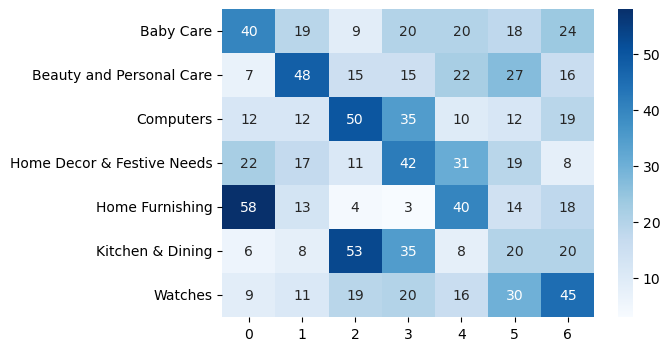

In [33]:
df_cm2 = pd.DataFrame(conf_mat2, index = [label for label in liste_cat],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm2, annot=True, cmap="Blues")

La matrice de confusion ne donne pas de clustering évident. C'est cohérent puisque les scores sont faibles pour ce modèle.

Nous avons ici présenté différentes approches de clustering à partir de données textuelles et de données visuelles.
Dans un prochain notebook intitulé *"traitement_avec_technique_recente"*, nous aborderons des techniques plus récentes.